# (29) Simulation -- full [draft]

**Motivation**: Added the object, finalized the code. <br>

In [1]:
# HIDE CODE


import os
import sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from model.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def show_thetaphi(t, p):
    fig, axes = create_figure(1, 4, (13, 2.5), tight_layout=True)
    im = axes[0].imshow(t, cmap='nipy_spectral')
    plt.colorbar(im, ax=axes[0])

    im = axes[2].imshow(p, cmap='hsv', vmin=0, vmax=2*np.pi)
    plt.colorbar(im, ax=axes[2])

    for ax in [axes[0], axes[2]]:
        ax.invert_yaxis()
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=ticks,
            yticks=ticks,
            xticklabels=ticklabels,
            yticklabels=ticklabels,
        )

    axes[1].axvline(np.deg2rad(fov), color='r', ls='--', label=f'{fov} deg')
    sns.histplot(
        t.ravel(), ax=axes[1], label=r'$\theta$',
        bins=np.linspace(0, np.pi/2, 91), stat='count')
    sns.histplot(
        p.ravel(), ax=axes[3], label=r'$\phi$', color='C0',
        bins=np.linspace(0, 2*np.pi, 37), stat='count')
    
    sns.histplot(
        p[t <= np.deg2rad(fov)], ax=axes[3], label=r'$\phi$' + f' (<{fov})', color='C1',
        bins=np.linspace(0, 2*np.pi, 37), stat='count')
    for ax in [axes[1], axes[3]]:
        ax.set_ylabel('')
        ax.legend(fontsize=8, loc='upper left')

    plt.show()
    
    
def show_xyzd(x, y, z, d, cmap='Spectral', grid=False):
    fig, axes = create_figure(1, 4, (12, 2.5), 'all', 'all', tight_layout=True)
    im = axes[0].imshow(x, cmap=cmap)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title(r'$\mathcal{x}$', y=1.02, fontsize=17)

    im = axes[1].imshow(y, cmap=cmap)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title(r'$\mathcal{y}$', y=1.02, fontsize=17)

    im = axes[2].imshow(z, cmap=cmap)
    plt.colorbar(im, ax=axes[2])
    axes[2].set_title(r'$\mathcal{z}$', y=1.02, fontsize=17)

    im = axes[3].imshow(d, cmap=cmap)
    plt.colorbar(im, ax=axes[3])
    axes[3].set_title(r'$\mathcal{d} = \sqrt{\mathcal{x}^2+\mathcal{y}^2+\mathcal{z}^2}$', y=1.02, fontsize=14)

    axes[-1].invert_yaxis()
    for ax in axes.flat:
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=ticks,
            yticks=ticks,
            xticklabels=ticklabels,
            yticklabels=ticklabels,
        )
    if grid:
        add_grid(axes)
    plt.show()
    
    
def hist_xyzd(x, y, d, z=None, bins=30):
    kws = {
        'bins': bins,
        'stat': 'percent',
    }
    fig, axes = create_figure(2, 4, (13, 5), sharey='all', constrained_layout=True)
    sns.histplot(x.ravel(), ax=axes[0, 0], **kws)
    sns.histplot(y.ravel(), ax=axes[0, 1], **kws)
    if z is not None:
        sns.histplot(z.ravel(), ax=axes[0, 2], **kws)
    sns.histplot(d.ravel(), ax=axes[0, 3], **kws)

    sns.histplot(x[of.theta < np.deg2rad(fov)], ax=axes[1, 0], **kws)
    sns.histplot(y[of.theta < np.deg2rad(fov)], ax=axes[1, 1], **kws)
    if z is not None:
        sns.histplot(z[of.theta < np.deg2rad(fov)], ax=axes[1, 2], **kws)
    sns.histplot(d[of.theta < np.deg2rad(fov)], ax=axes[1, 3], **kws)
    
    axes[0, 0].set_title(r'$x$', y=1.02, fontsize=17)
    axes[0, 1].set_title(r'$y$', y=1.02, fontsize=17)
    axes[0, 2].set_title(r'$z$', y=1.02, fontsize=17)
    axes[0, 3].set_title(r'$d$', y=1.02, fontsize=17)
    
    plt.show()
    

def show_velocity(v, cmap='Spectral_r', grid=False):
    rho, phi = vel2polar(v)
    vminmax = np.max(np.abs(v))
    kws = dict(
        cmap='bwr',
        vmax=vminmax,
        vmin=-vminmax,
    )
    fig, axes = create_figure(1, 4, (12, 2.5), 'all', 'all', tight_layout=True)
    im = axes[0].imshow(v[..., 0], **kws)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title(r'$v_x$', y=1.02, fontsize=17)

    im = axes[1].imshow(v[..., 1], **kws)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title(r'$v_y$', y=1.02, fontsize=17)

    im = axes[2].imshow(rho, cmap=cmap)
    plt.colorbar(im, ax=axes[2])
    axes[2].set_title(r'$\rho$', y=1.02, fontsize=17)

    im = axes[3].imshow(phi, cmap='hsv', vmin=0, vmax=2*np.pi)
    plt.colorbar(im, ax=axes[3])
    axes[3].set_title(r'$\phi$', y=1.02, fontsize=14)

    axes[-1].invert_yaxis()
    for ax in axes.flat:
        ax.tick_params(labelsize=10)
        ax.set(
            xticks=ticks,
            yticks=ticks,
            xticklabels=ticklabels,
            yticklabels=ticklabels,
        )
    if grid:
        add_grid(axes)
    plt.show()


from skimage.transform import resize

def show_opticflow(v):
    fig, axes = create_figure(1, 3, (12, 4), constrained_layout=True)
    axes[0].quiver(
        range(-2, 2 + 1),
        range(-2, 2 + 1),
        resize(v[..., 0], (4+1,) * 2),
        resize(v[..., 1], (4+1,) * 2),
        # scale=150,
    )
    axes[1].quiver(
        range(-4, 4 + 1),
        range(-4, 4 + 1),
        resize(v[..., 0], (8+1,) * 2),
        resize(v[..., 1], (8+1,) * 2),
        # scale=100,
    )
    axes[2].quiver(
        range(-8, 8 + 1),
        range(-8, 8 + 1),
        resize(v[..., 0], (16+1,) * 2),
        resize(v[..., 1], (16+1,) * 2),
        # scale=100,
    )
    ax_square(axes)
    plt.show()

## Test

In [3]:
fix = np.array([[0, 0], [0.3, 0], [0, 0.3], [0.3, 0.3]])
fix.shape

(4, 2)

In [4]:
fov = 45
res = 1

self = of = OpticFlow(
    fov=fov,
    res=res,
).compute_coords(fix=fix)

of.dim

91

In [5]:
ticks, ticklabels = zip(*[
    (i, str(int(np.round(np.rad2deg(x)))))
    for i, x in enumerate(of.span) if i % 15 == 0
])
ticklabels

('-45', '-30', '-15', '0', '15', '30', '45')

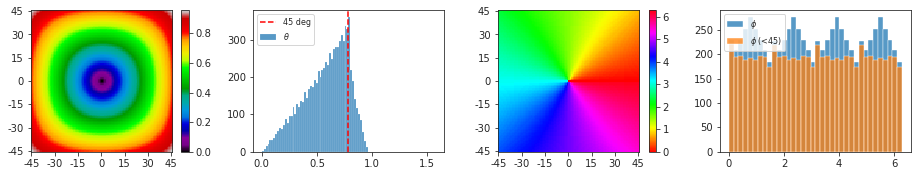

In [6]:
theta, phi = self2polar(of.alpha[..., 0], of.alpha[..., 1])
show_thetaphi(theta, phi)

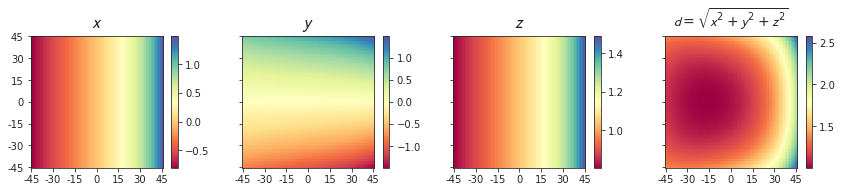

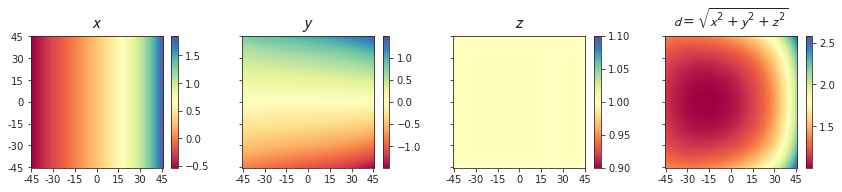

array([0.3, 0. ])

In [7]:
i = 1
X = np.einsum('ij, mnj -> mni', of.R[i], of.x[i])

show_xyzd(of.x[i, ..., 0], of.x[i, ..., 1], of.x[i, ..., 2], sp_lin.norm(of.x[i, ...], axis=-1))
show_xyzd(X[..., 0], X[..., 1], X[..., 2], sp_lin.norm(X, axis=-1))

fix[i]

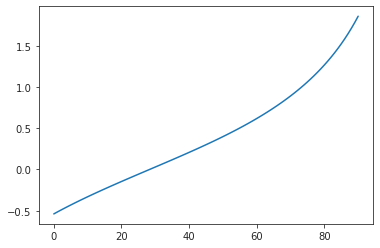

In [8]:
plt.plot(X[..., 0][0])

In [9]:
np.min(X[..., 0]), np.max(X[..., 0])

(-0.538461538461538, 1.857142857142858)

In [10]:
np.tan(np.arctan(0.3) - np.deg2rad(45)), np.tan(np.arctan(0.3) + np.deg2rad(45))

(-0.5384615384615384, 1.8571428571428574)

---
## START

In [27]:
obj_pos = np.array([
    [-0.2, 0, 0.2],
    [-0.2, 0, 0.4],
    [-0.2, 0, 0.6],
    [-0.2, 0, 0.8],
    [-0.2, 0, 1.0],
    [-0.2, 0.2, 1.0],
    [0, 0, 0.5],
    [0, 0, 1.0],
    [0, 0, 0.5],
    [0, 0, 1.0],
]).T
obj_vel = np.array([
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [0, 0, 0],
    [0, 0, 0],
]).T
obj_pos.shape, obj_vel.shape

((3, 10), (3, 10))

In [28]:
vel = np.array([
    [0, 0, 10],
    [0, 0, -10],
    [5, 5, 0],
    [1, -2, 0],
    [3, 0, 10],
    [3, 3, 1],
    [-2, 1, 5],
], dtype=float).T
vel.shape

(3, 7)

In [29]:
vel

array([[  0.,   0.,   5.,   1.,   3.,   3.,  -2.],
       [  0.,   0.,   5.,  -2.,   0.,   3.,   1.],
       [ 10., -10.,   0.,   0.,  10.,   1.,   5.]])

In [30]:
v_transl_obj, x, v_rot, v_transl, alpha_dot = of.compute_flow(vel, obj_pos, obj_vel)
v_transl_obj.shape, x.shape, v_rot.shape, v_transl.shape, alpha_dot.shape

((4, 91, 91, 3, 7, 10),
 (4, 91, 91, 3, 7, 10),
 (4, 91, 91, 3, 7, 10),
 (4, 91, 91, 3, 7, 10),
 (4, 91, 91, 2, 7, 10))

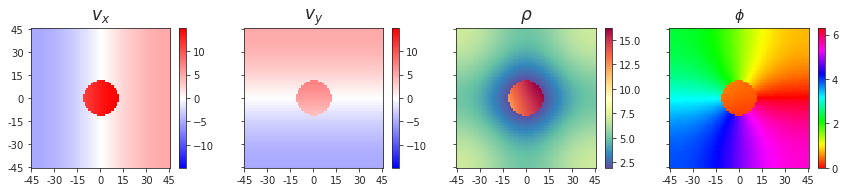

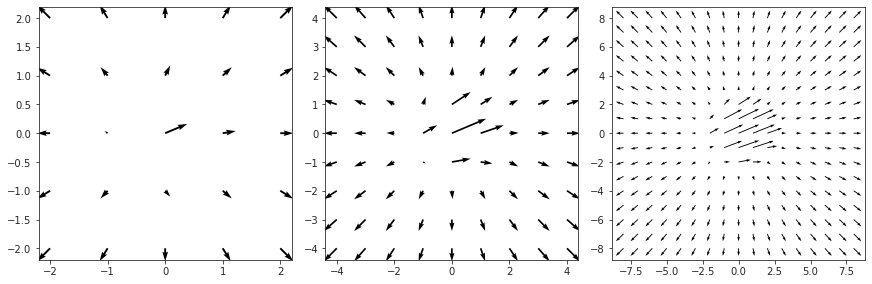

In [31]:
i, j, k = 0, 0, 7
show_velocity(alpha_dot[i, ..., j, k])
show_opticflow(alpha_dot[i, ..., j, k])

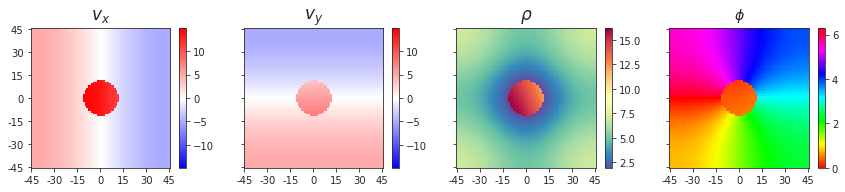

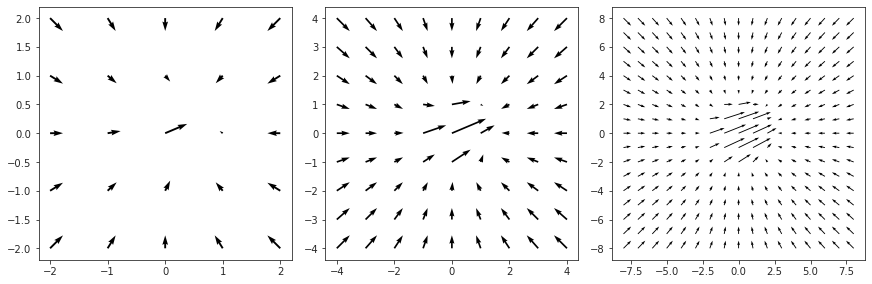

In [32]:
i, j, k = 0, 1, 7
show_velocity(alpha_dot[i, ..., j, k])
show_opticflow(alpha_dot[i, ..., j, k])

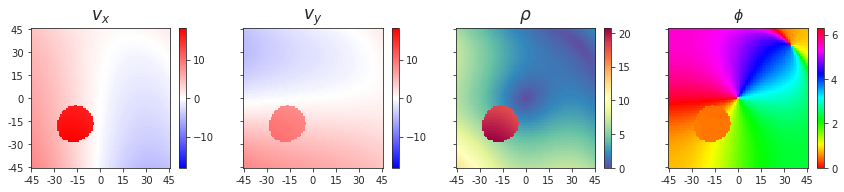

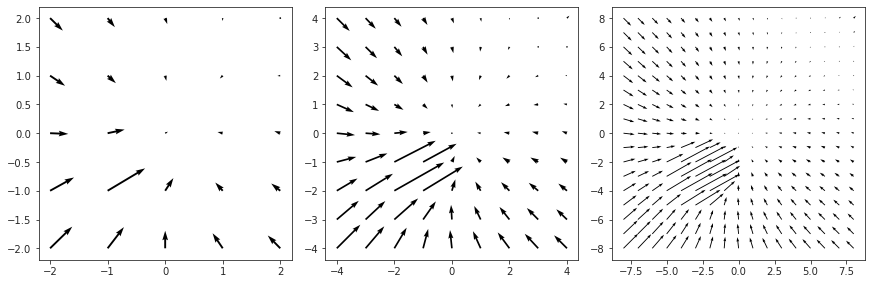

In [17]:
# Was: v_transl[~nans] = v_transl_obj[~nans] . . . (instead of correct: v_transl[~nans] += v_transl_obj[~nans])

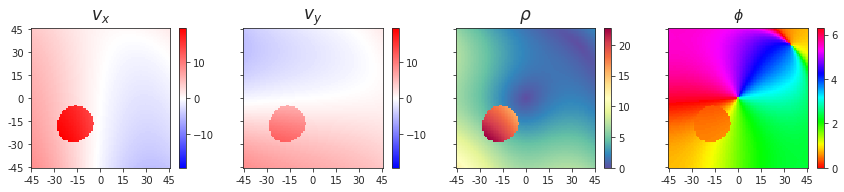

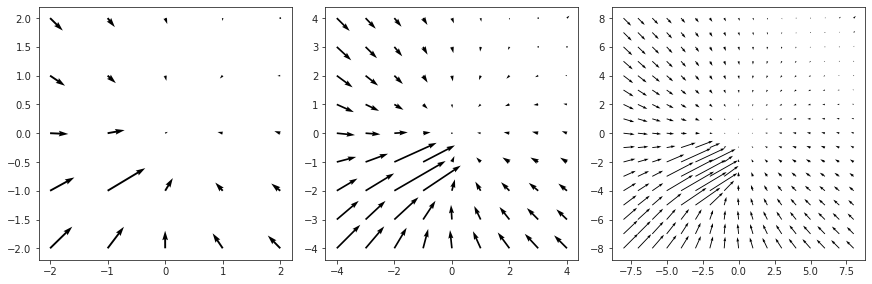

In [33]:
i, j, k = 3, 1, 7
show_velocity(alpha_dot[i, ..., j, k])
show_opticflow(alpha_dot[i, ..., j, k])

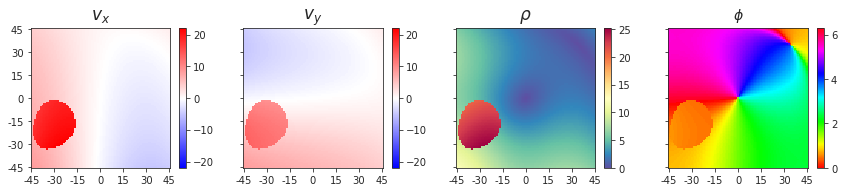

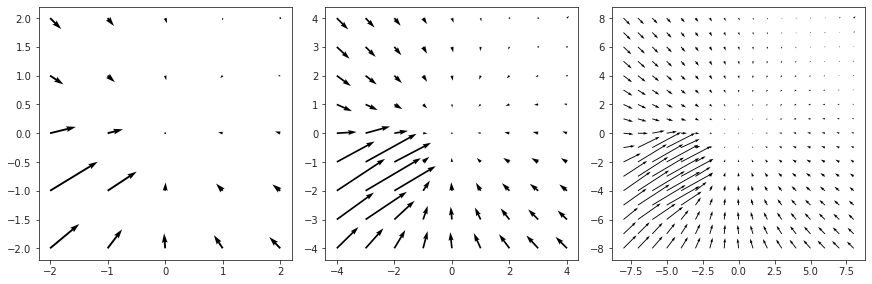

In [22]:
# Was: v_transl[~nans] = v_transl_obj[~nans] . . . (instead of correct: v_transl[~nans] += v_transl_obj[~nans])

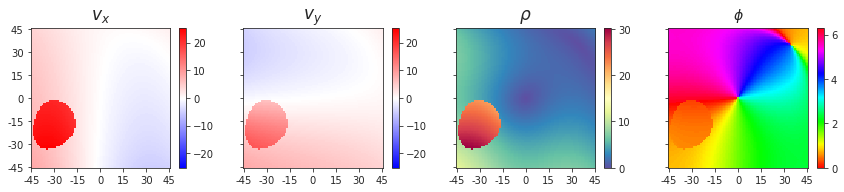

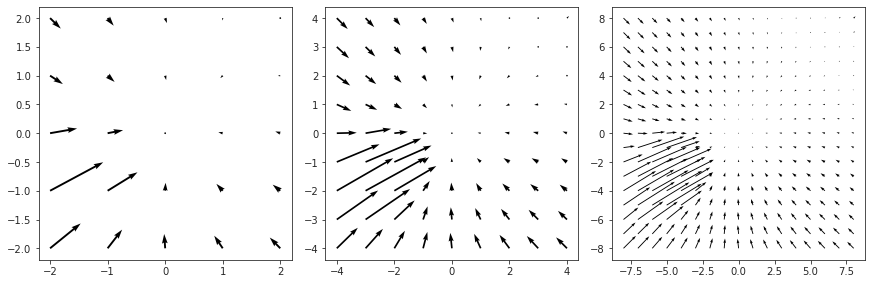

In [34]:
i, j, k = 3, 1, 3
show_velocity(alpha_dot[i, ..., j, k])
show_opticflow(alpha_dot[i, ..., j, k])

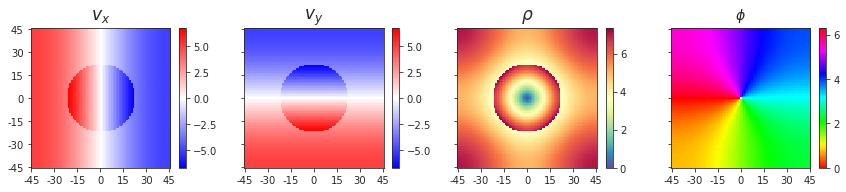

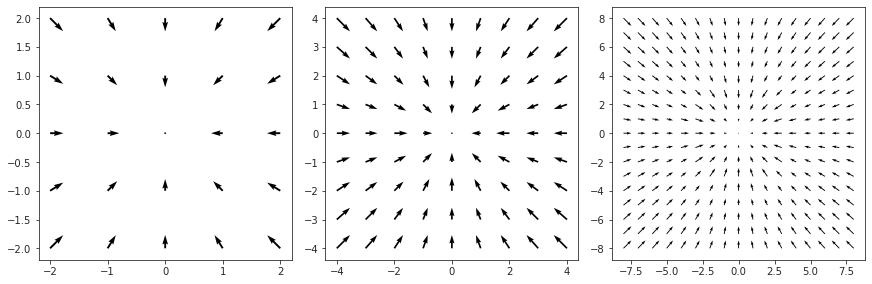

In [38]:
i, j, k = 0, 1, -2
show_velocity(alpha_dot[i, ..., j, k])
show_opticflow(alpha_dot[i, ..., j, k])

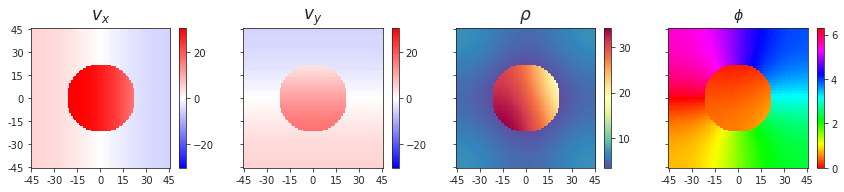

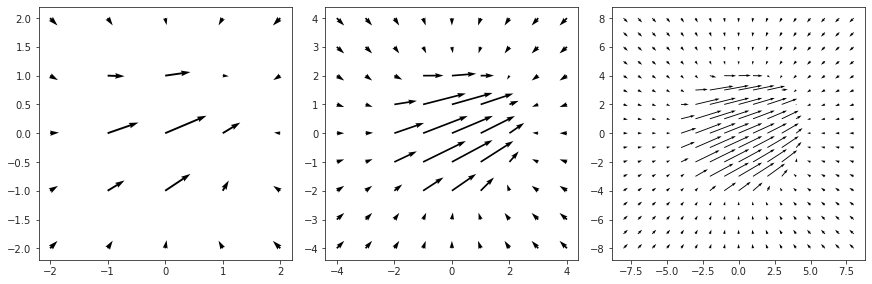

In [39]:
i, j, k = 0, 1, -4
show_velocity(alpha_dot[i, ..., j, k])
show_opticflow(alpha_dot[i, ..., j, k])

In [40]:
v_transl.shape

(4, 91, 91, 3, 7, 10)

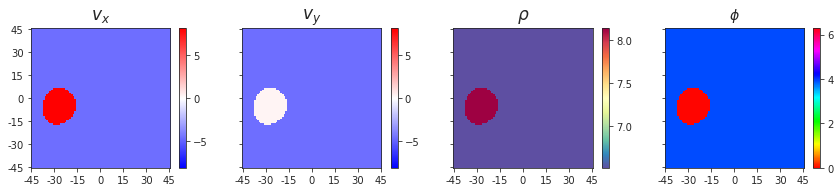

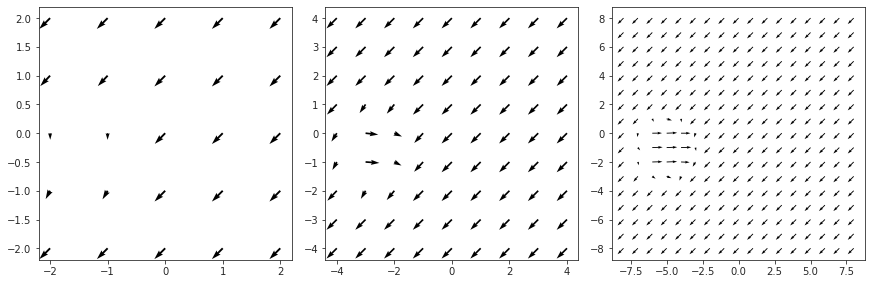

In [41]:
i = 3
j = 2
k = 5
show_velocity(v_transl[i, ..., :2, j, k])
show_opticflow(v_transl[i, ..., :2, j, k])

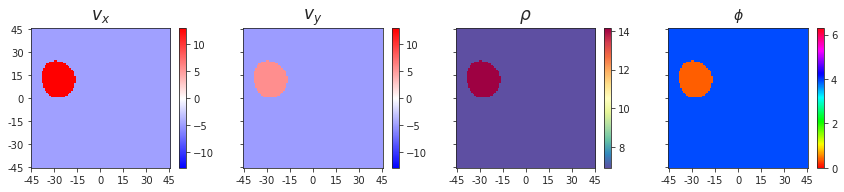

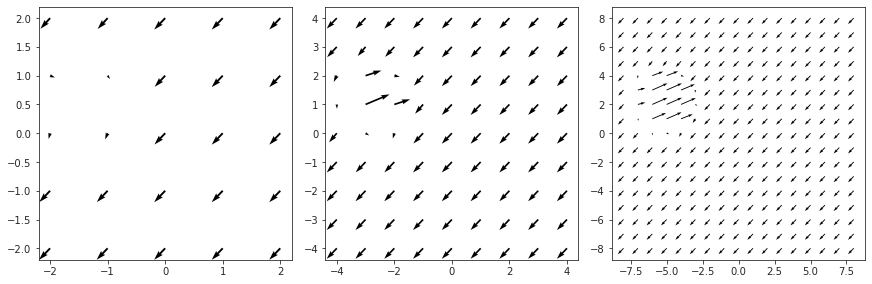

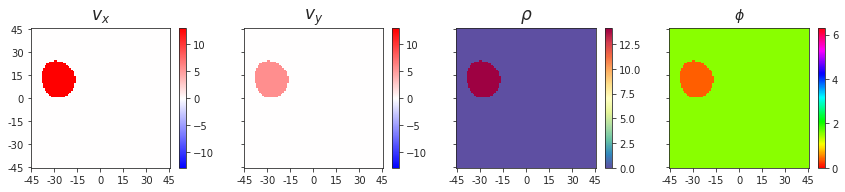

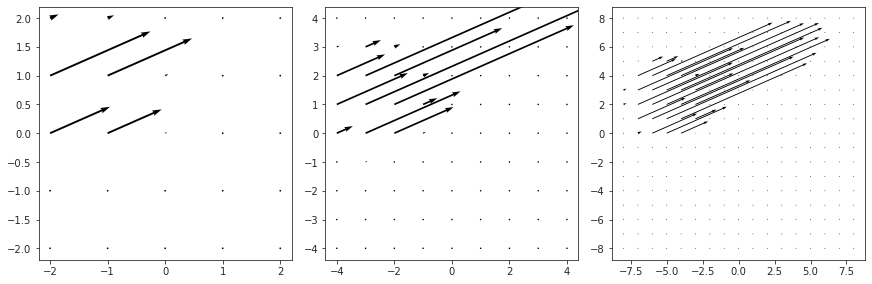

In [42]:
i = 1
j = 4
k = 5
show_velocity(v_transl[i, ..., :2, j, k])
show_opticflow(v_transl[i, ..., :2, j, k])

In [43]:
self.fix[i], self.vel[: ,j], collections.Counter(np.round(v_transl[i, ..., :2, j, k], 12).ravel())

(array([0.3, 0. , 1. ]),
 array([ 3.,  0., 10.]),
 Counter({0.0: 15738, 12.930654850486: 412, 5.7: 412}))

In [46]:
x_real = np.einsum('aij, axyjbc -> axyibc', of.R, x)
x.shape, x_real.shape

((4, 91, 91, 3, 7, 10), (4, 91, 91, 3, 7, 10))

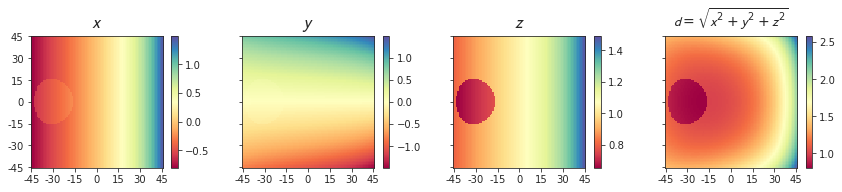

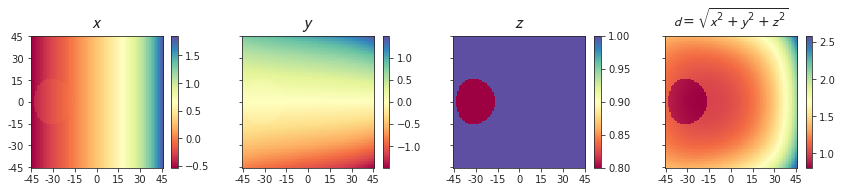

In [47]:
i = 1
j = 2
k = 3
_tmp = x[i, ..., j, k]
norm = sp_lin.norm(_tmp, axis=-1, check_finite=False)
show_xyzd(_tmp[..., 0], _tmp[..., 1], _tmp[..., 2], norm)

_tmp = x_real[i, ..., j, k]
norm_real = sp_lin.norm(_tmp, axis=-1, check_finite=False)
show_xyzd(_tmp[..., 0], _tmp[..., 1], _tmp[..., 2], norm_real)

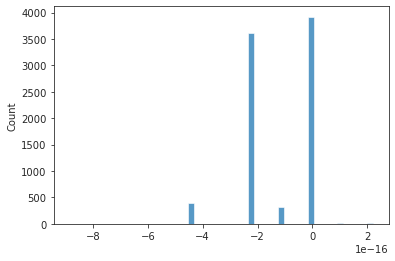

In [48]:
eps = norm_real - norm
sns.histplot(eps.ravel());

## END
---

In [14]:
v_obj = np.array([13.5, 5.7, 0]).reshape(3, 1)
v_obj = of._compute_v_tr(v_obj, mask)
v_obj.shape

(4, 91, 91, 3, 1)

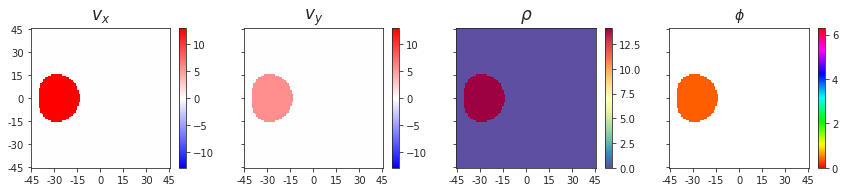

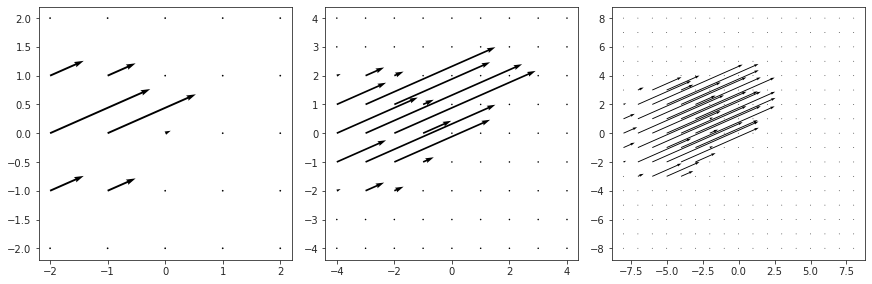

In [15]:
show_velocity(v_obj[i, ..., :2, 0])
show_opticflow(v_obj[i, ..., :2, 0])

In [13]:
obj_pos = np.array([
    [-0.2, 0, 0.2],
    [-0.2, 0, 0.4],
    [-0.2, 0, 0.6],
    [-0.2, 0, 0.8],
    [-0.2, 0, 1.0],
    [-0.2, 0.2, 1.0],
    [0, 0, 0.2],
    [0, 0, 1.0],
]).T
obj_vel = np.array([
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
    [13.5, 5.7, 0],
]).T
obj_pos.shape, obj_vel.shape

((3, 8), (3, 8))

In [14]:
vel = np.array([
    [0, 0, 10],
    [0, 0, -10],
    [5, 5, 0],
    [1, -2, 0],
    [3, 0, 10],
    [3, 3, 1],
    [-2, 1, 5],
], dtype=float).T
vel.shape

(3, 7)

In [15]:
vel

array([[  0.,   0.,   5.,   1.,   3.,   3.,  -2.],
       [  0.,   0.,   5.,  -2.,   0.,   3.,   1.],
       [ 10., -10.,   0.,   0.,  10.,   1.,   5.]])

In [16]:
%%time

alpha_dot, v_transl, v_rot = of.compute_flow(vel)

CPU times: user 56.7 ms, sys: 20.1 ms, total: 76.9 ms
Wall time: 74.8 ms


In [17]:
v_transl_obj = of.add_obj(obj_pos, obj_vel)
v_transl_obj.shape

(4, 91, 91, 3, 8)

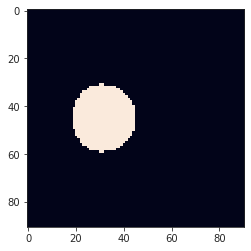

In [21]:
plt.imshow(v_transl_obj[0, ..., 0, 3])

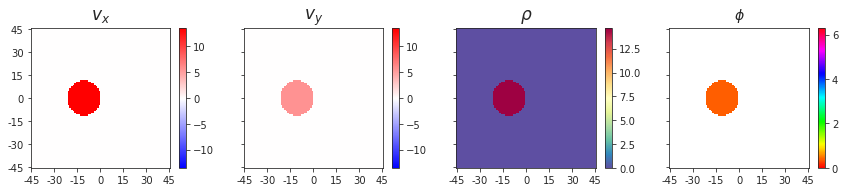

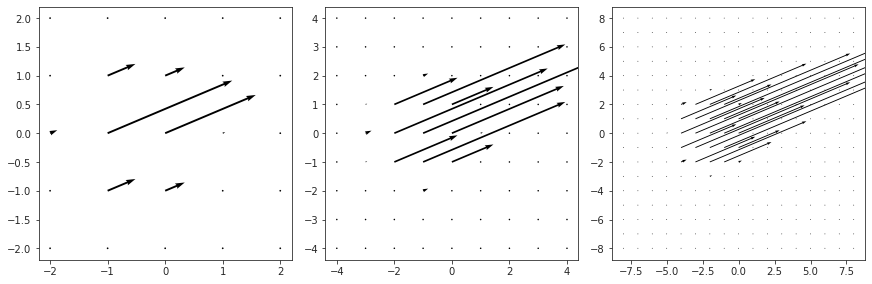

In [40]:
test = v_transl_obj[0, ..., :2, 4]
show_velocity(test)
show_opticflow(test)

In [24]:
test.shape

(91, 91, 2)

In [19]:
v = v_transl - v_rot
v.shape

(4, 91, 91, 3, 7)

In [20]:
test = dc(v)
test.shape

(4, 91, 91, 3, 7)

In [21]:
mask_ultra = np.repeat(np.repeat(np.repeat(np.expand_dims(np.expand_dims(np.expand_dims(
    mask, 0), -1),-1), 3, -2), 7, -1), 4, 0)
mask_ultra.shape

(4, 91, 91, 3, 7)

In [22]:
test[mask_ultra] = np.repeat(v_obj, 7, -1)[mask_ultra]

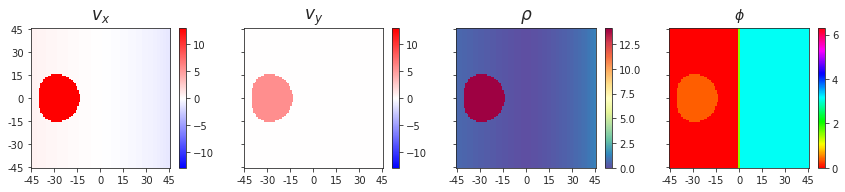

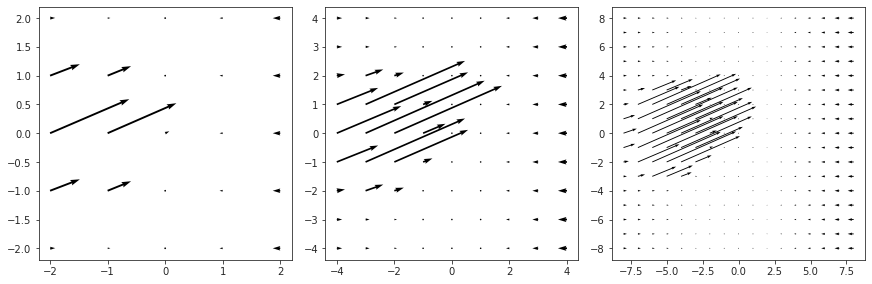

In [24]:
final = of._compute_alpha_dot(test)
final.shape

(4, 91, 91, 2, 7)

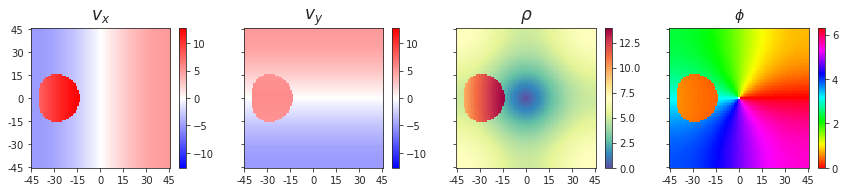

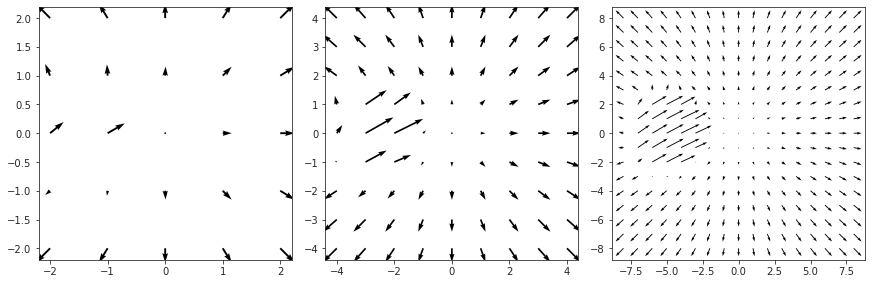

In [25]:
i, j = 0, 0
show_velocity(final[i, ..., j])
show_opticflow(final[i, ..., j])

In [28]:
self = of

In [32]:
self.gamma = np.concatenate([
    np.tan(self.alpha),
    np.ones((self.dim,) * 2 + (1,)),
], axis=-1)

In [33]:
self.gamma.shape

(91, 91, 3)

In [34]:
self.alpha.shape

(91, 91, 2)

In [38]:
gamma_r = np.einsum('aij, mnj -> amni', self.R, self.gamma)
gamma_r.shape

(4, 91, 91, 3)

In [36]:
self.R.shape, self.gamma.shape

((4, 3, 3), (91, 91, 3))

In [39]:
self.gamma[..., 0].shape

(91, 91)

## TODO

When computing object velocity, make sure to use the mask to provide correct x,y,z...

In [22]:
alpha_dot.shape, v.shape, v_transl.shape, v_rot.shape

((4, 91, 91, 2, 7), (4, 91, 91, 3, 7), (4, 91, 91, 3, 7), (4, 91, 91, 3, 7))

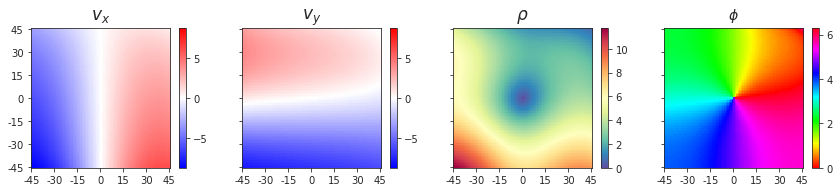

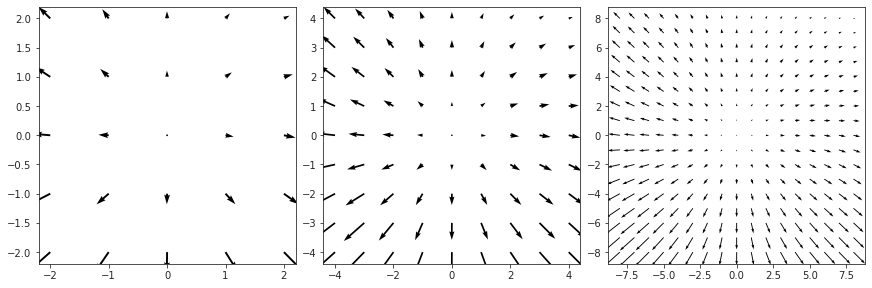

In [23]:
i, j = 3, 4
show_velocity(alpha_dot[i, ..., j])
show_opticflow(alpha_dot[i, ..., j])

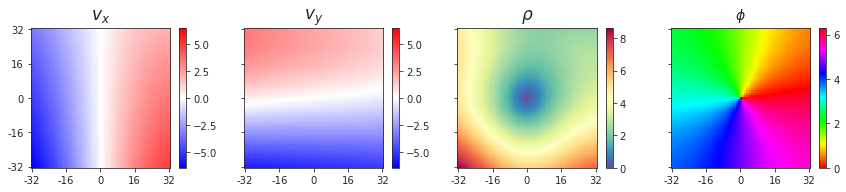

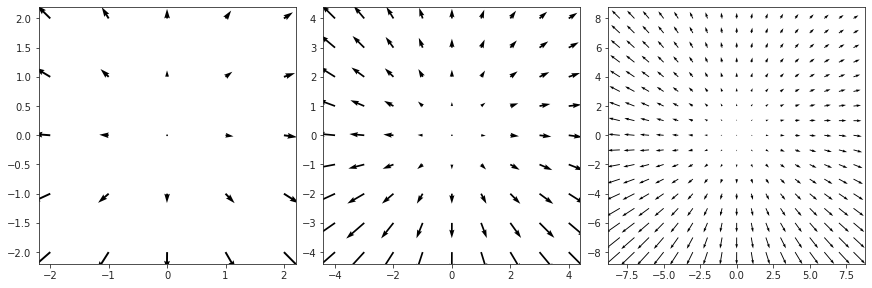

In [24]:
i, j = 3, 4
show_velocity(alpha_dot[i, ..., j])
show_opticflow(alpha_dot[i, ..., j])

In [24]:
rho, theta = vel2polar(alpha_dot[i, ..., j])
np.unravel_index(np.argmin(rho), rho.shape)

(45, 45)

In [25]:
rho[45, 45]

2.0517770523394535e-15

In [26]:
np.round(alpha_dot[:, of.dim//2][:, of.dim//2], 14)

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]],

       [[ 0., -0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]],

       [[ 0., -0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -0.,  0., -0.,  0.,  0.,  0.]],

       [[-0.,  0.,  0.,  0., -0., -0., -0.],
        [-0.,  0., -0.,  0., -0., -0., -0.]]])

In [27]:
of.vel.shape

(3, 7)

## Before object adding

fixation: [0. 0. 1.],   velocity: [ 0.  0. 10.]

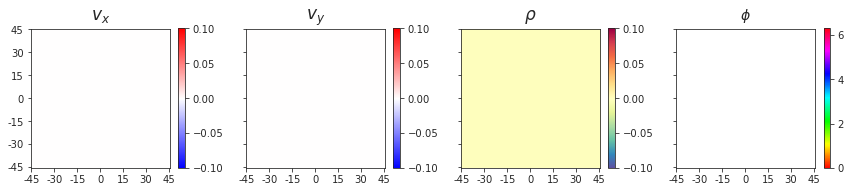

/home/hadi/anaconda3/lib/python3.8/site-packages/matplotlib/quiver.py:686: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/hadi/anaconda3/lib/python3.8/site-packages/matplotlib/quiver.py:686: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


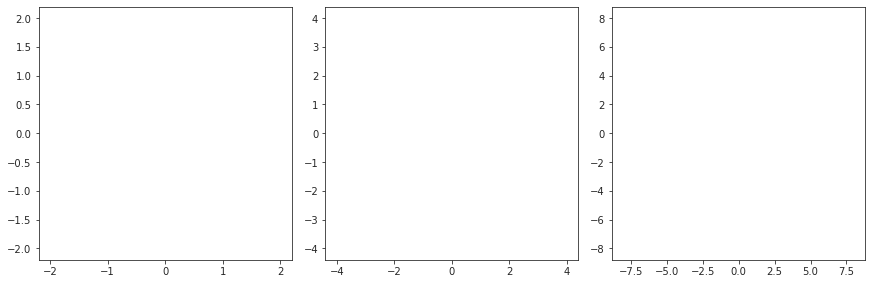

--------------------------------------------------------------------------------

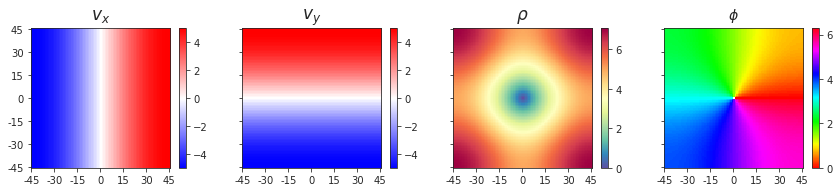

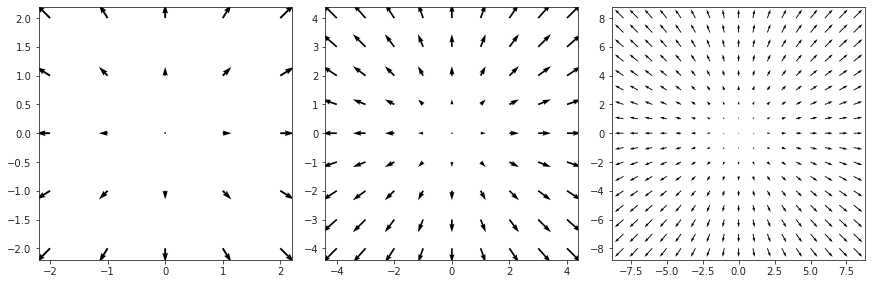

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0. 0. 1.],   velocity: [  0.   0. -10.]

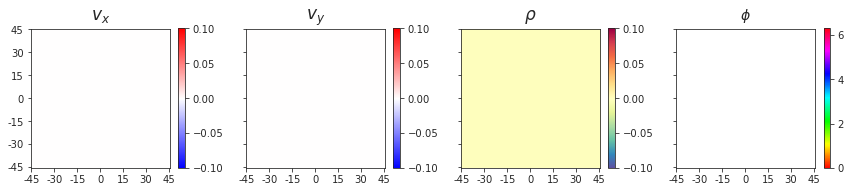

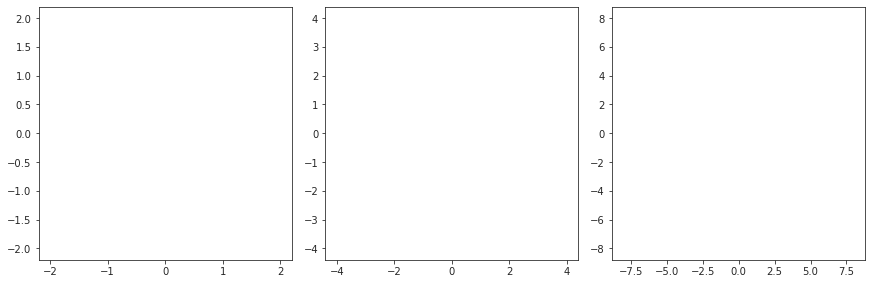

--------------------------------------------------------------------------------

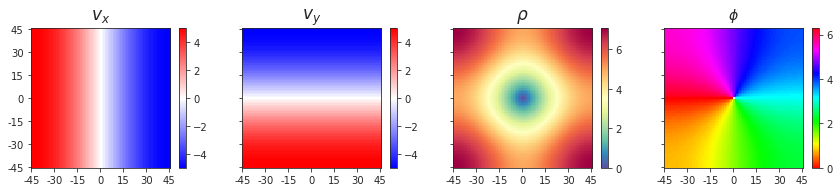

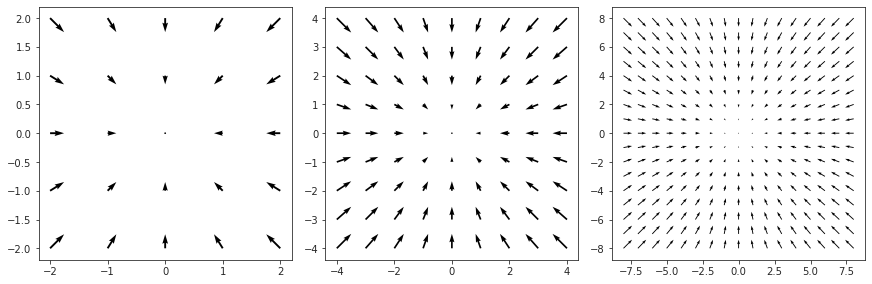

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0. 0. 1.],   velocity: [5. 5. 0.]

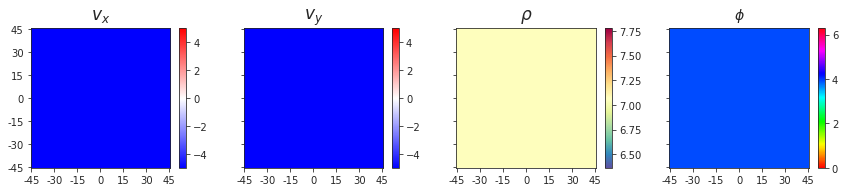

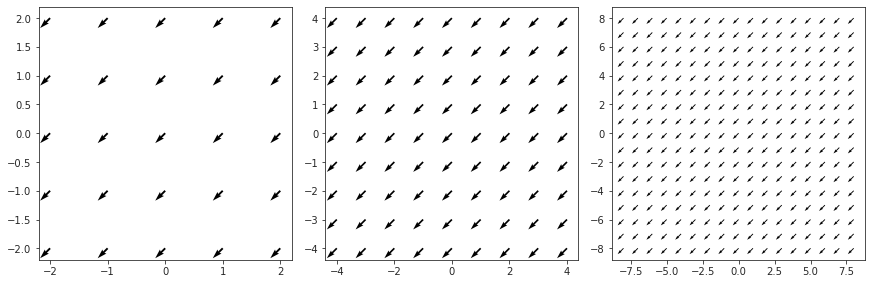

--------------------------------------------------------------------------------

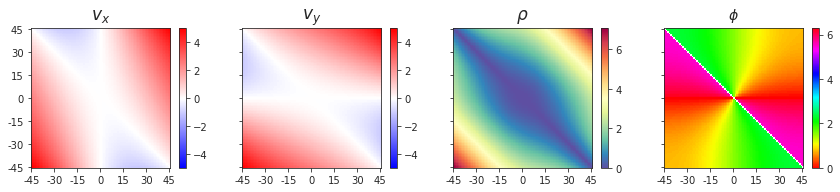

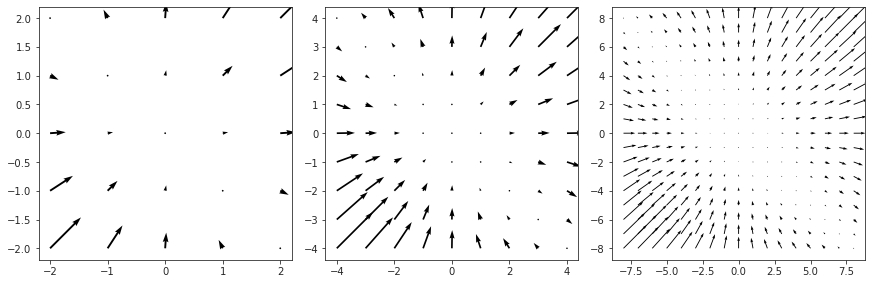

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0. 0. 1.],   velocity: [ 1. -2.  0.]

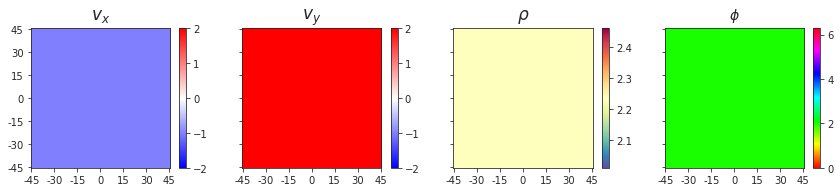

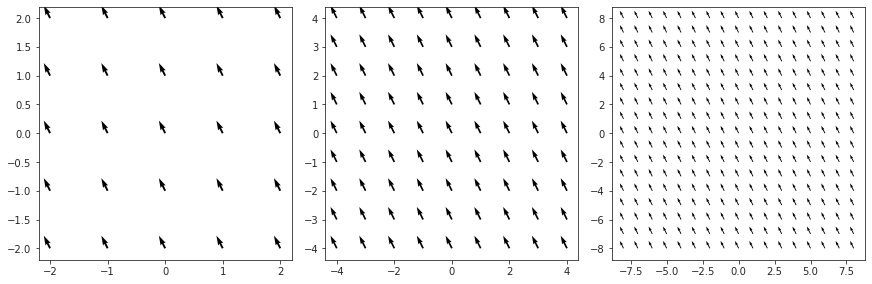

--------------------------------------------------------------------------------

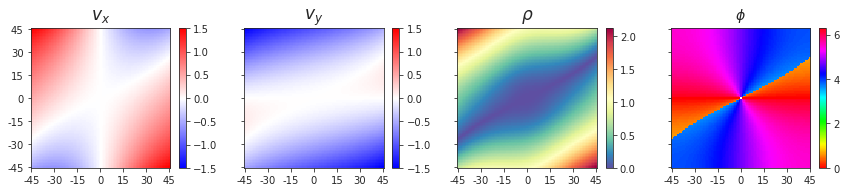

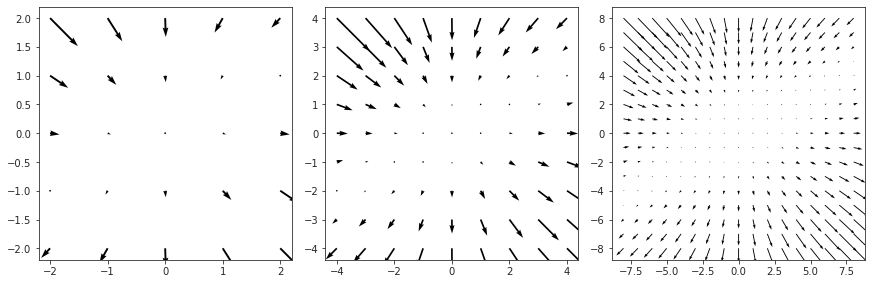

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0. 0. 1.],   velocity: [ 3.  0. 10.]

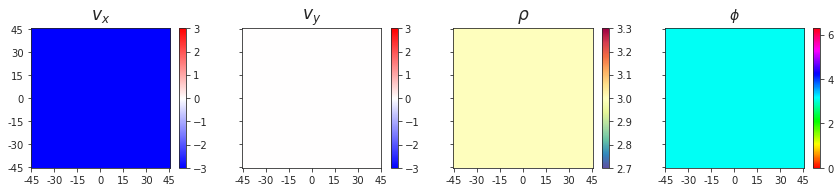

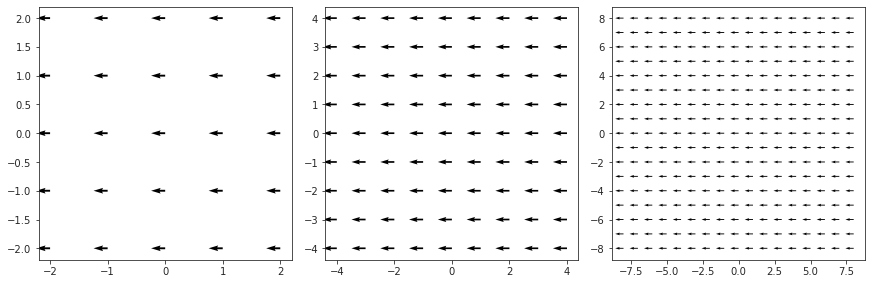

--------------------------------------------------------------------------------

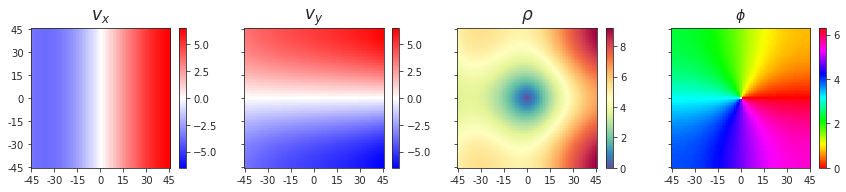

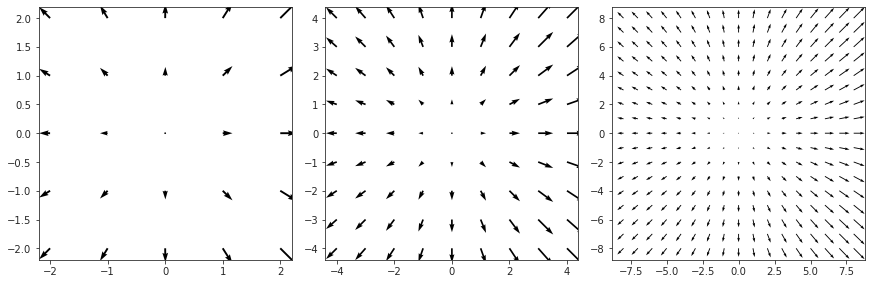

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0. 0. 1.],   velocity: [3. 3. 1.]

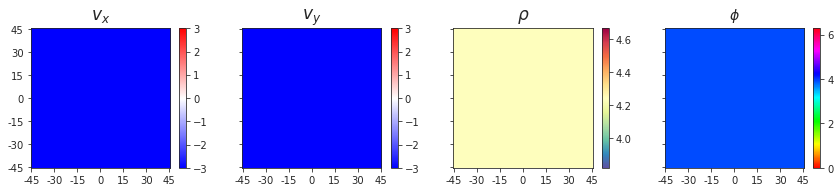

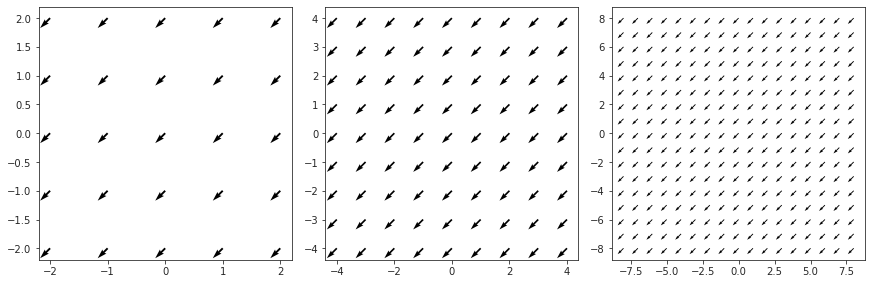

--------------------------------------------------------------------------------

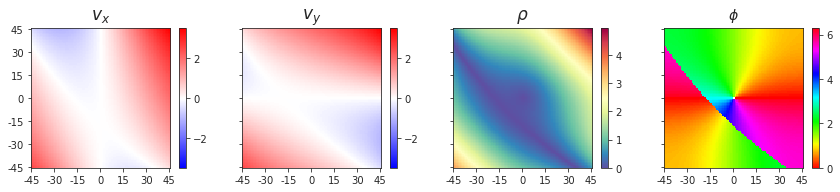

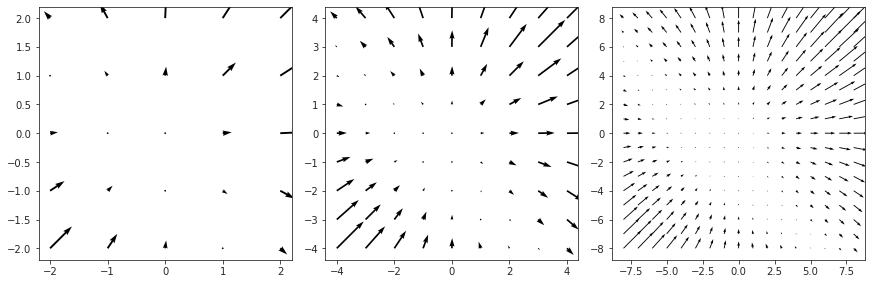

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0. 0. 1.],   velocity: [-2.  1.  5.]

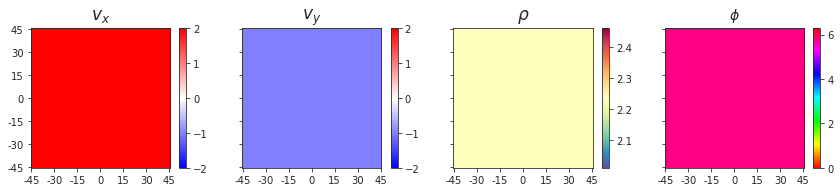

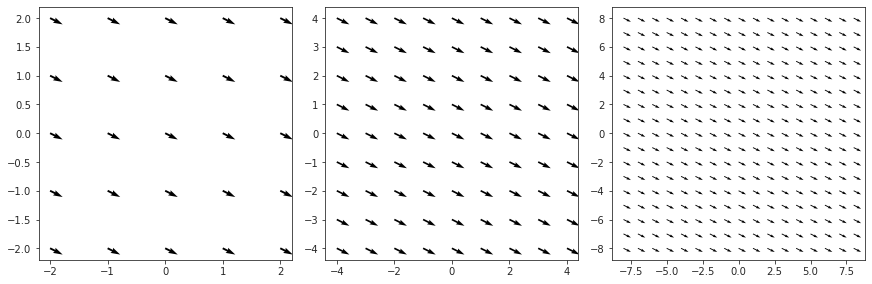

--------------------------------------------------------------------------------

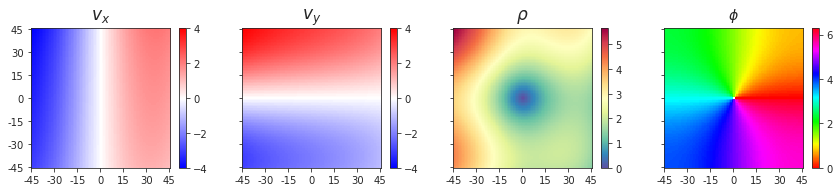

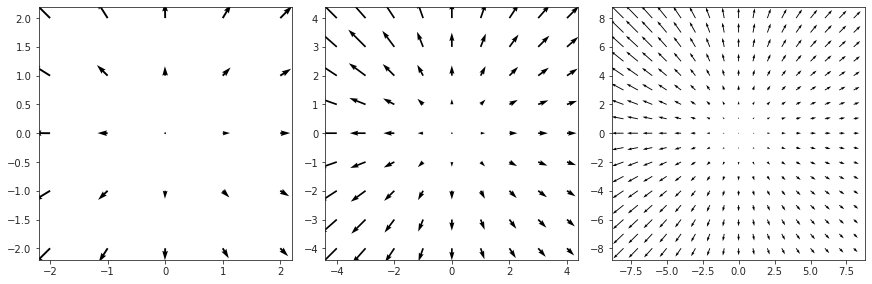

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.  1. ],   velocity: [ 0.  0. 10.]

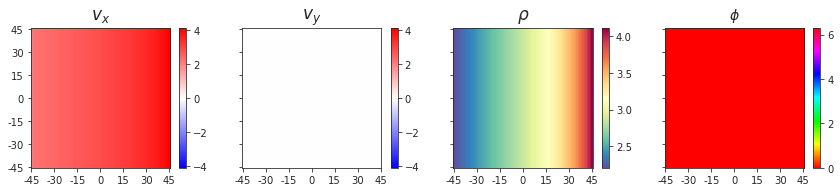

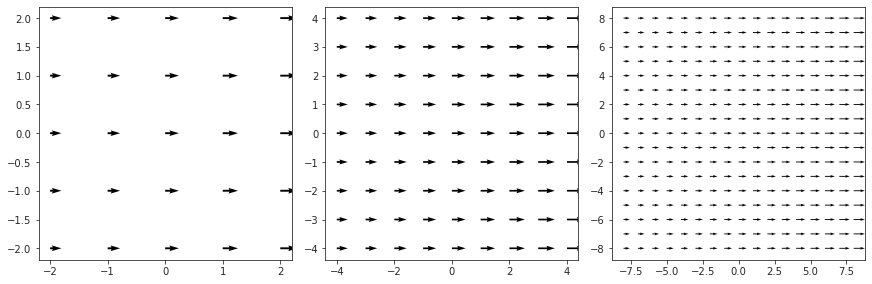

--------------------------------------------------------------------------------

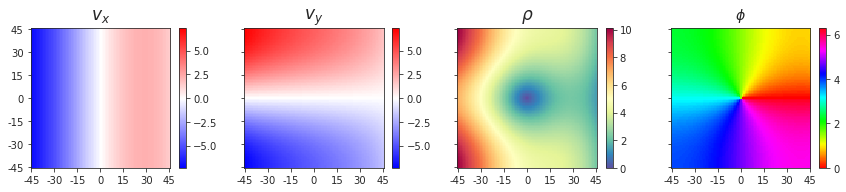

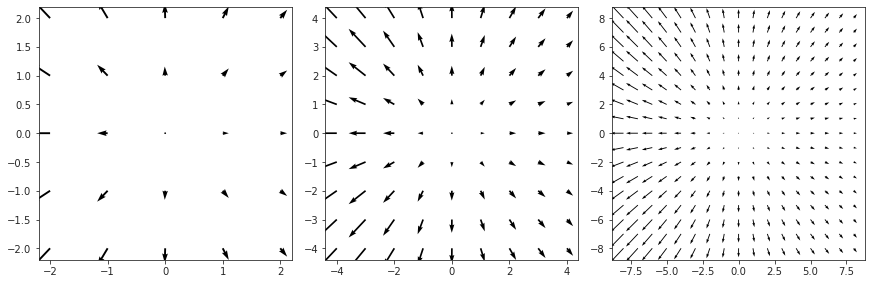

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.  1. ],   velocity: [  0.   0. -10.]

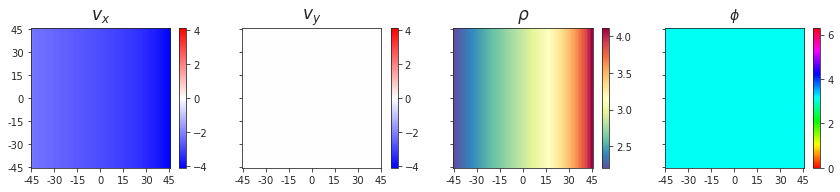

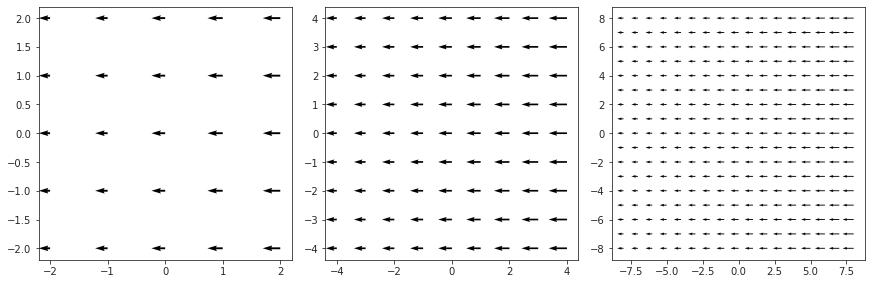

--------------------------------------------------------------------------------

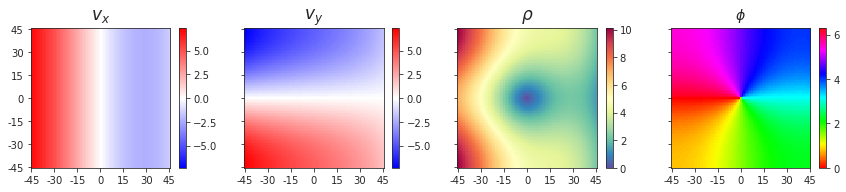

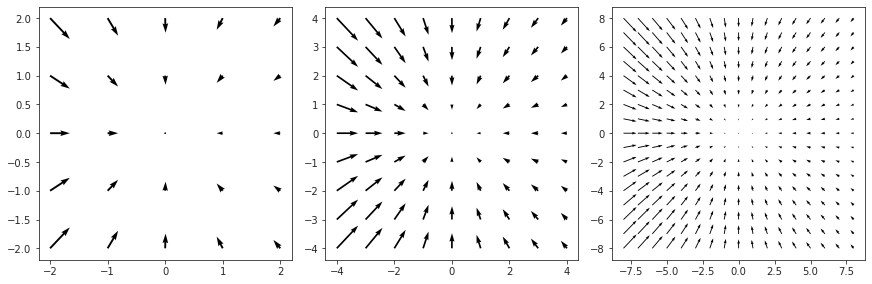

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.  1. ],   velocity: [5. 5. 0.]

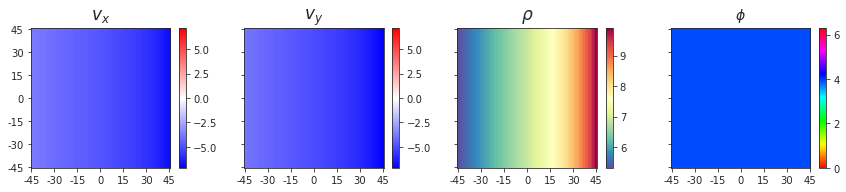

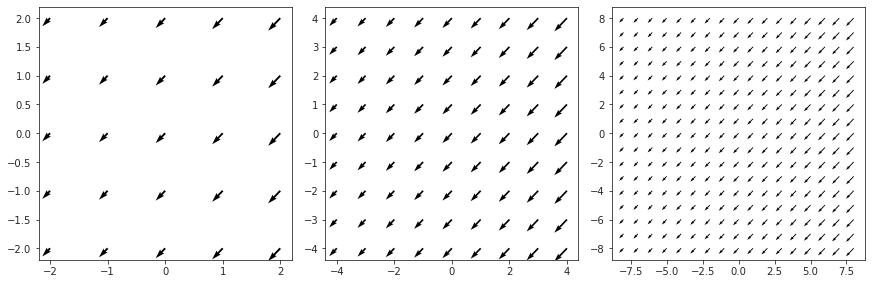

--------------------------------------------------------------------------------

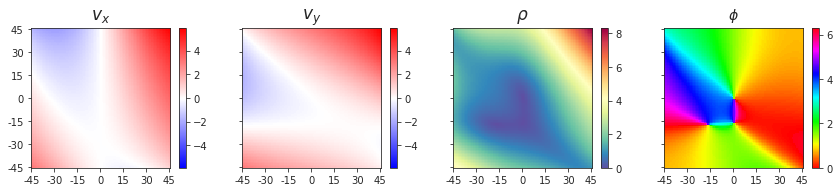

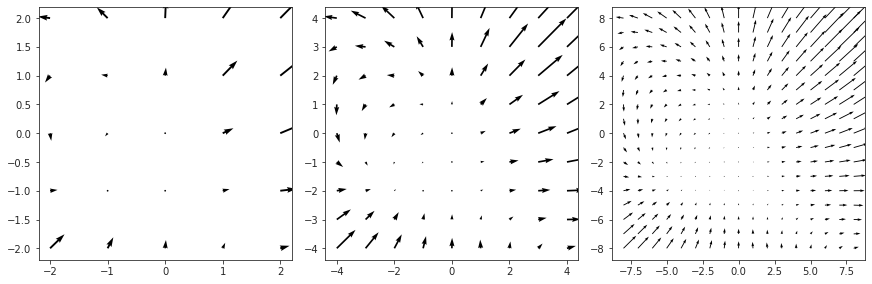

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.  1. ],   velocity: [ 1. -2.  0.]

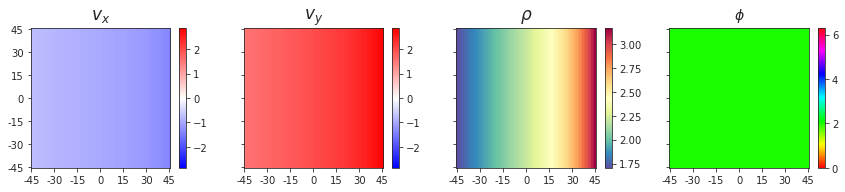

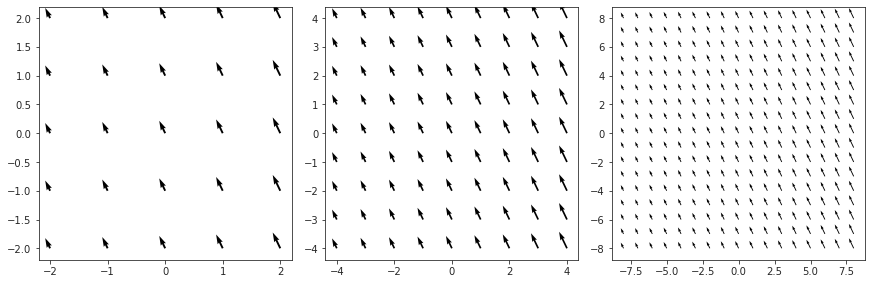

--------------------------------------------------------------------------------

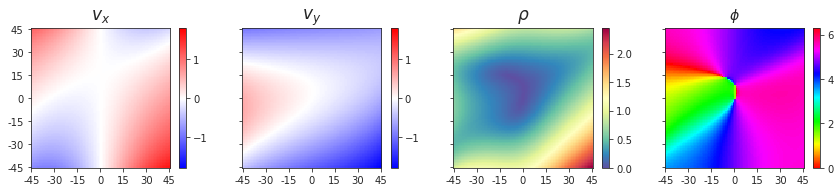

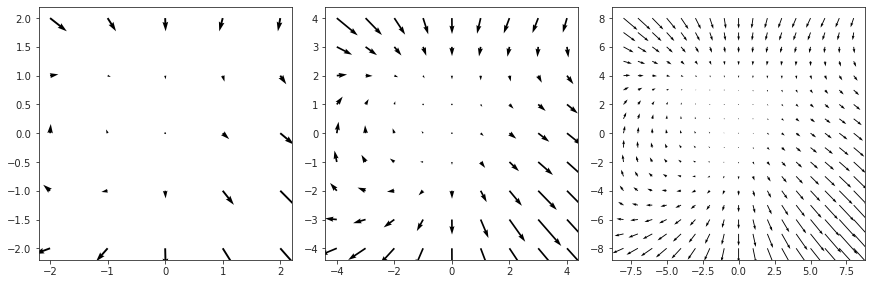

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.  1. ],   velocity: [ 3.  0. 10.]

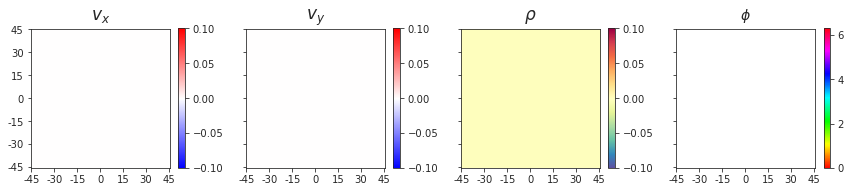

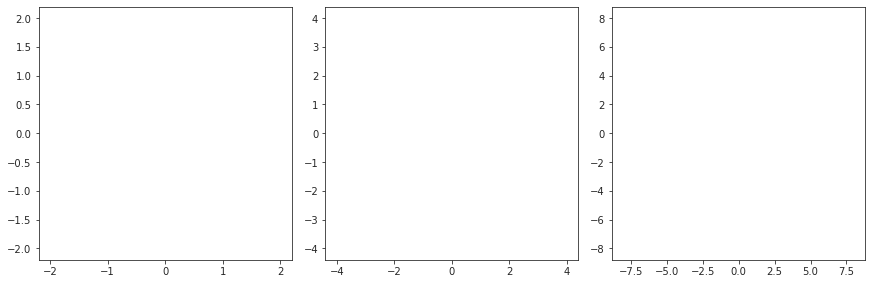

--------------------------------------------------------------------------------

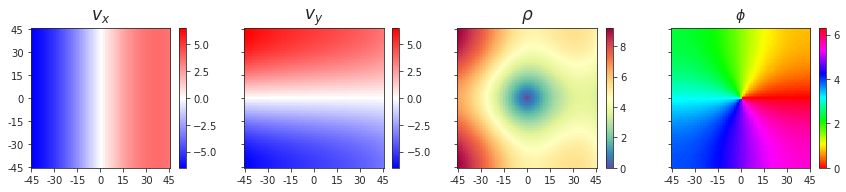

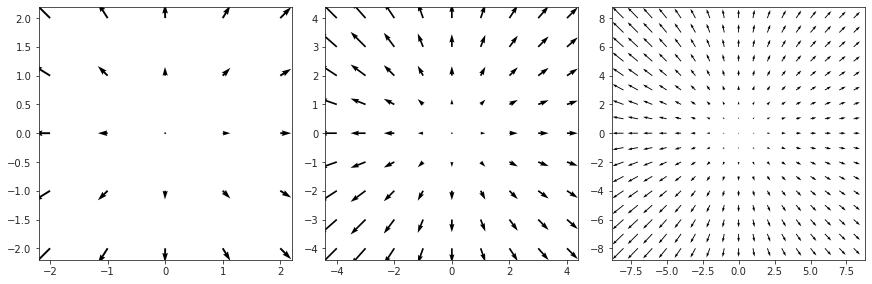

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.  1. ],   velocity: [3. 3. 1.]

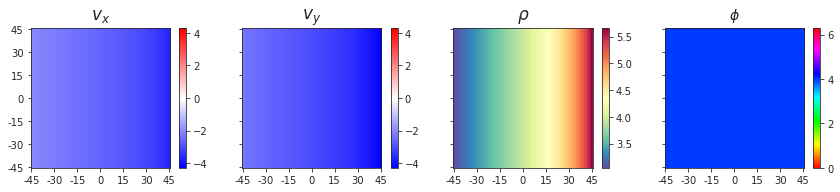

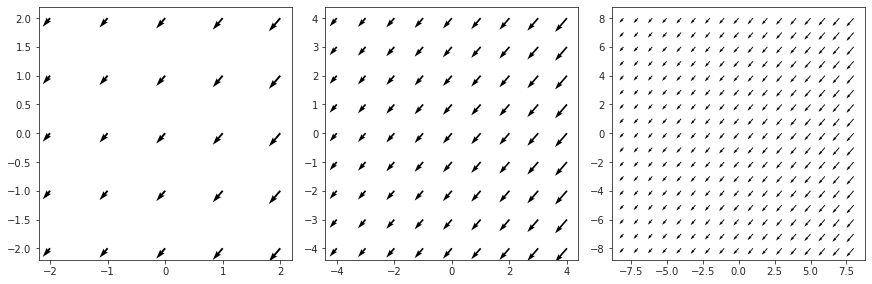

--------------------------------------------------------------------------------

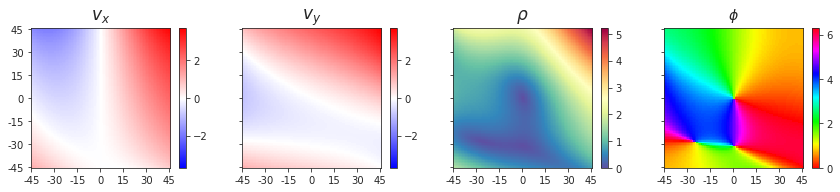

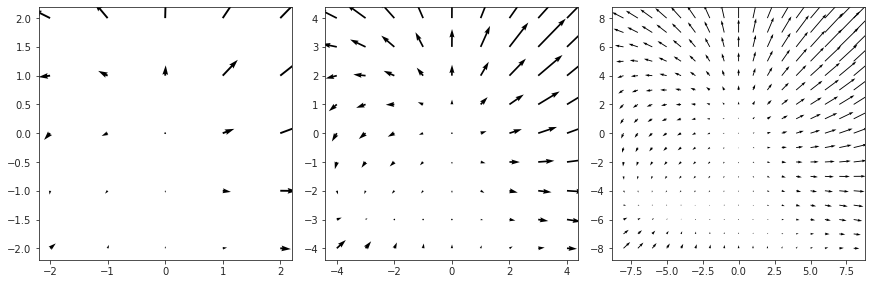

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.  1. ],   velocity: [-2.  1.  5.]

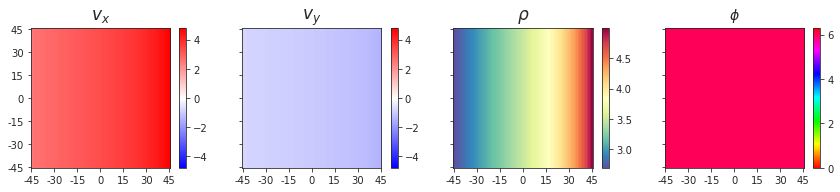

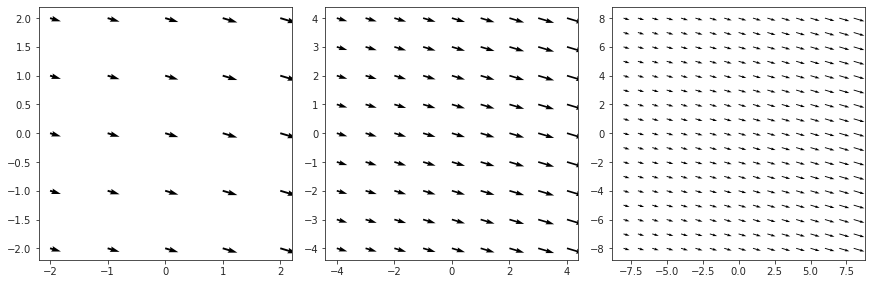

--------------------------------------------------------------------------------

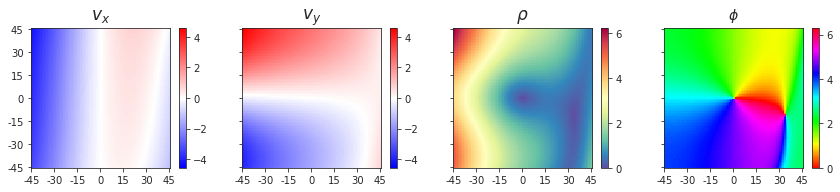

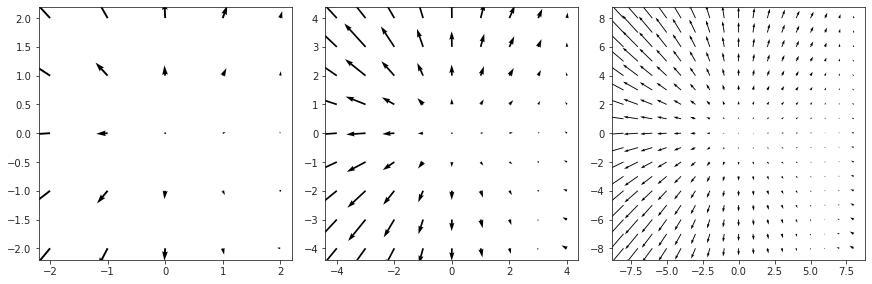

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.  0.3 1. ],   velocity: [ 0.  0. 10.]

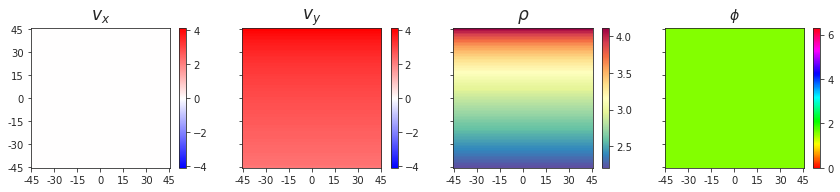

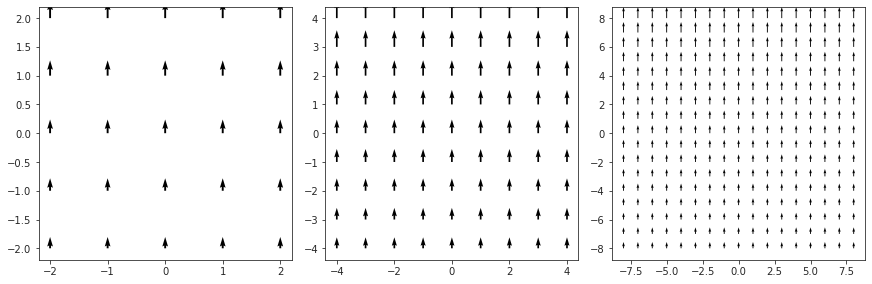

--------------------------------------------------------------------------------

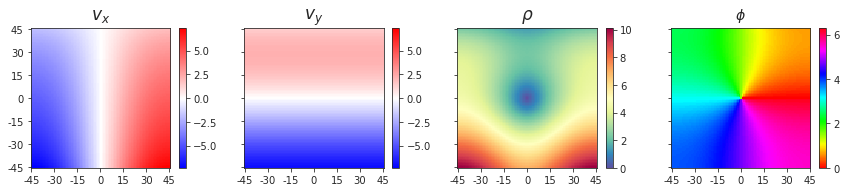

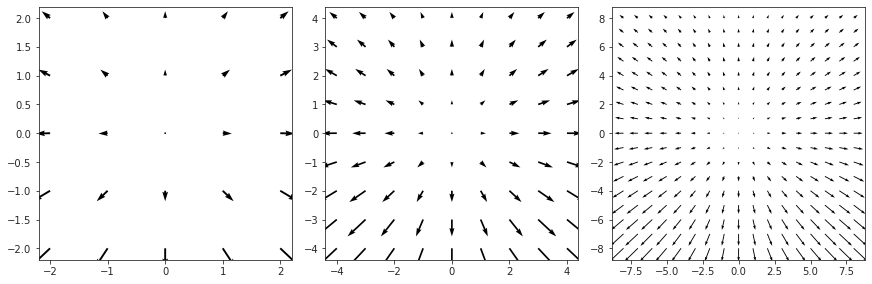

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.  0.3 1. ],   velocity: [  0.   0. -10.]

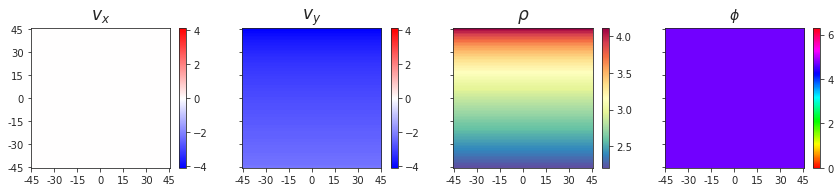

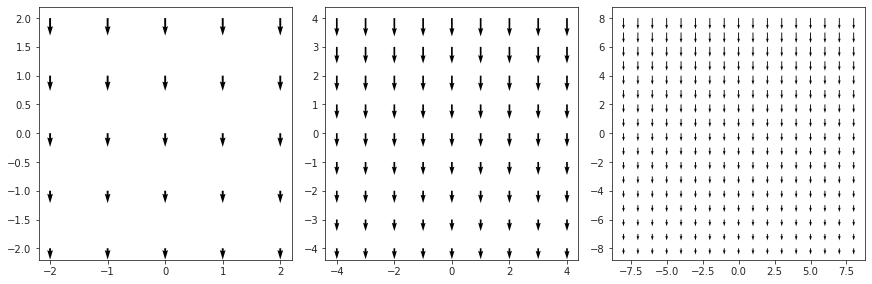

--------------------------------------------------------------------------------

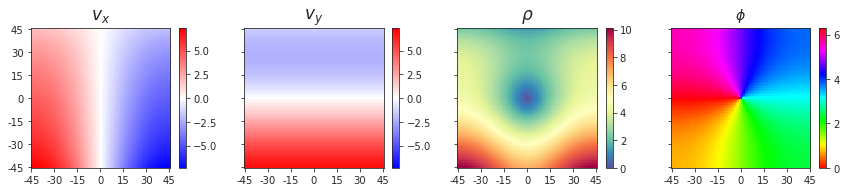

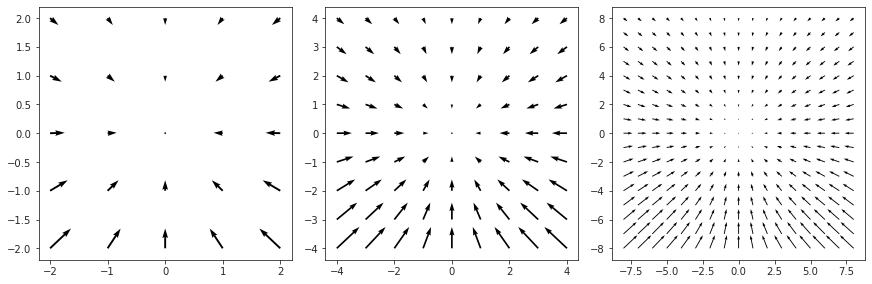

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.  0.3 1. ],   velocity: [5. 5. 0.]

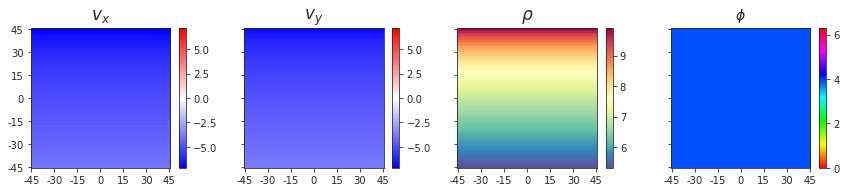

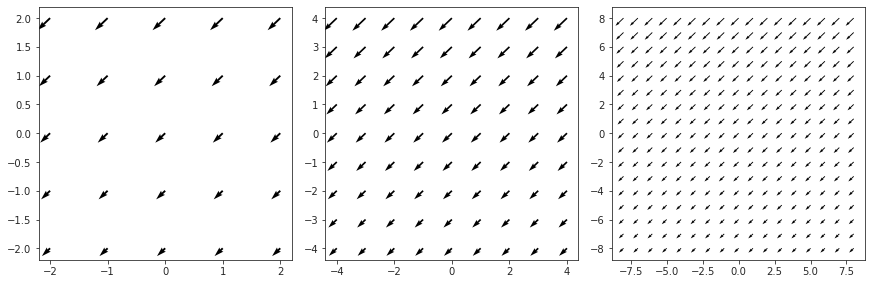

--------------------------------------------------------------------------------

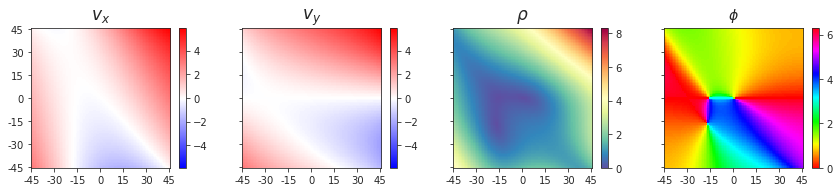

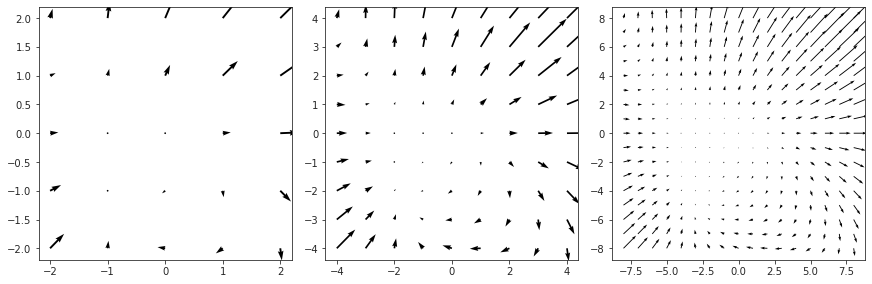

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.  0.3 1. ],   velocity: [ 1. -2.  0.]

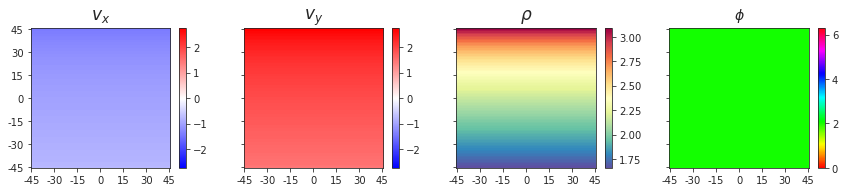

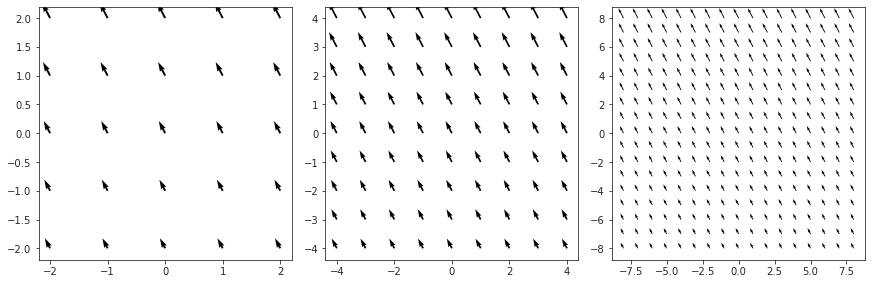

--------------------------------------------------------------------------------

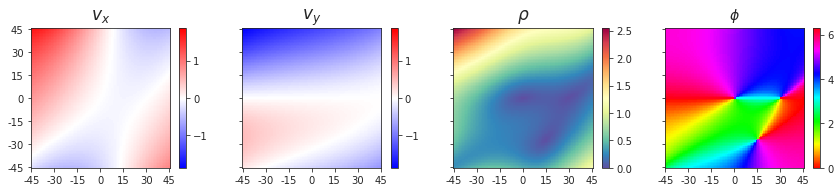

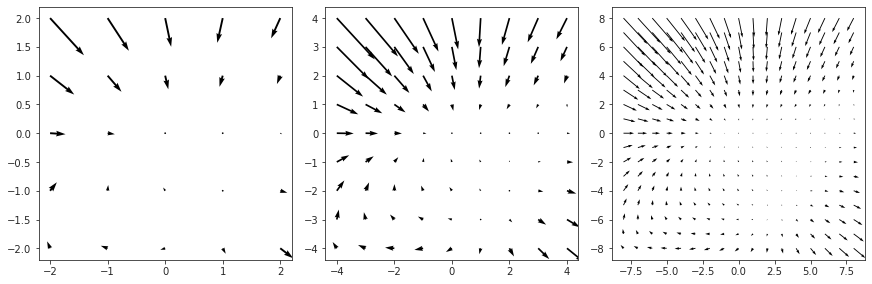

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.  0.3 1. ],   velocity: [ 3.  0. 10.]

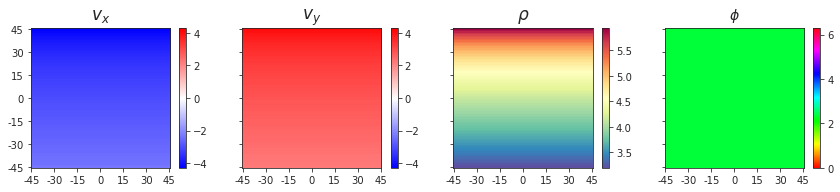

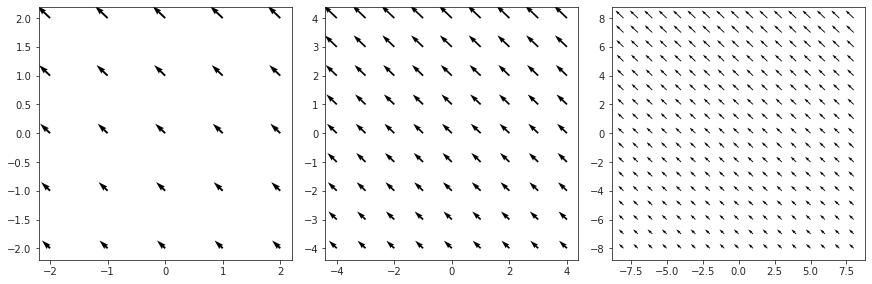

--------------------------------------------------------------------------------

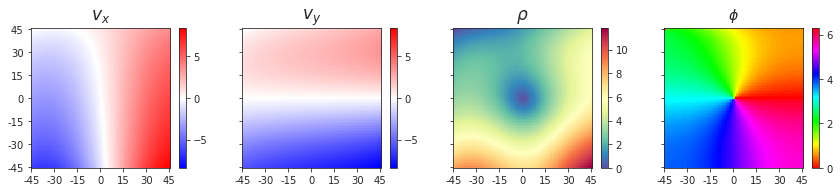

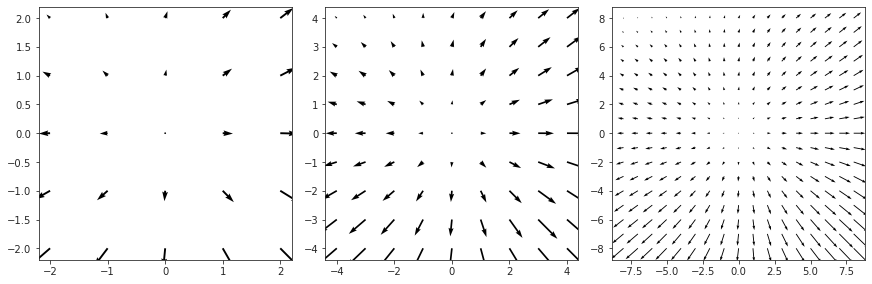

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.  0.3 1. ],   velocity: [3. 3. 1.]

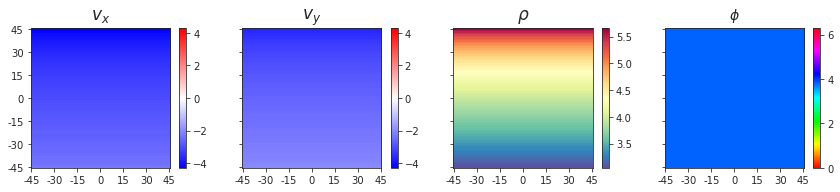

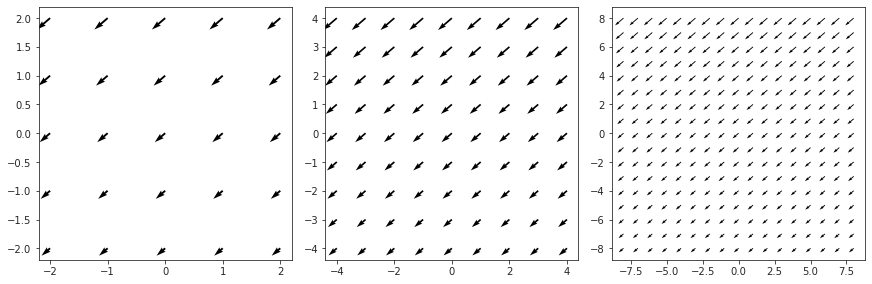

--------------------------------------------------------------------------------

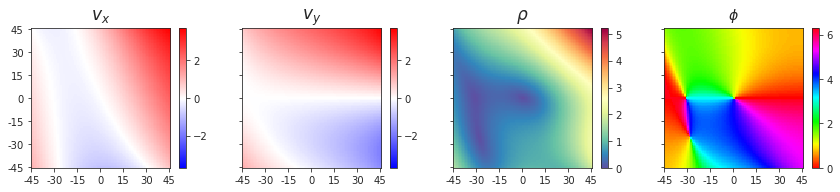

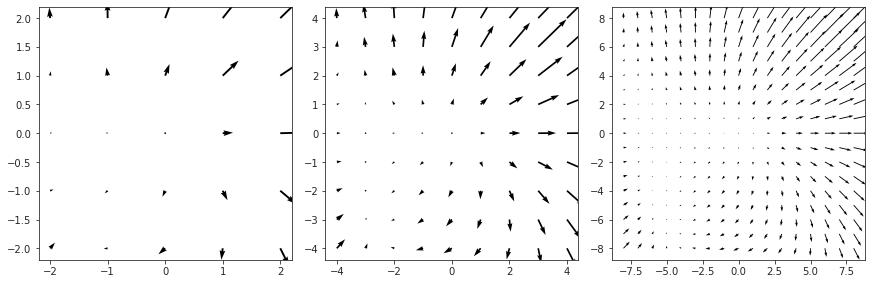

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.  0.3 1. ],   velocity: [-2.  1.  5.]

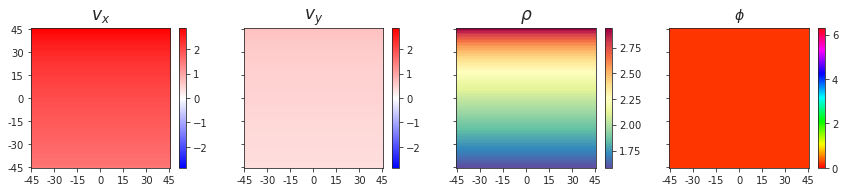

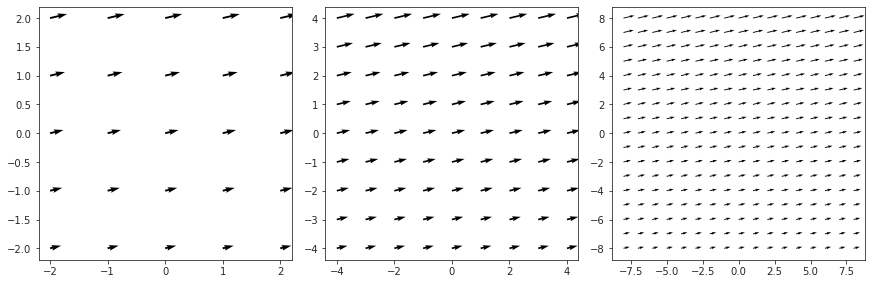

--------------------------------------------------------------------------------

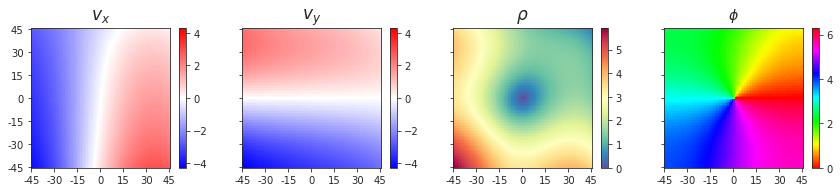

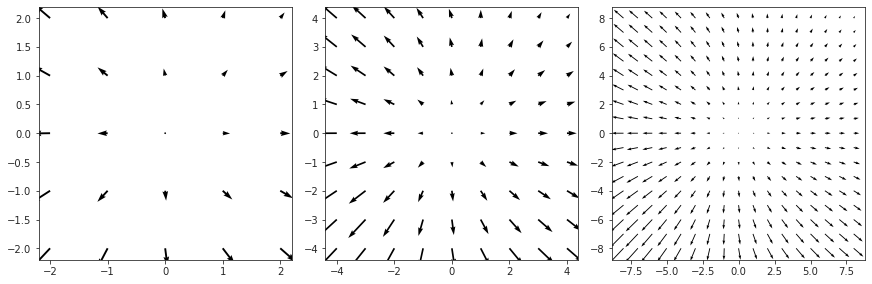

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.3 1. ],   velocity: [ 0.  0. 10.]

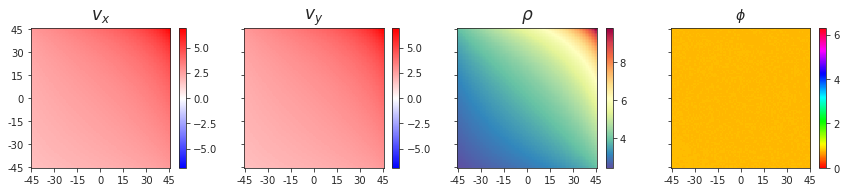

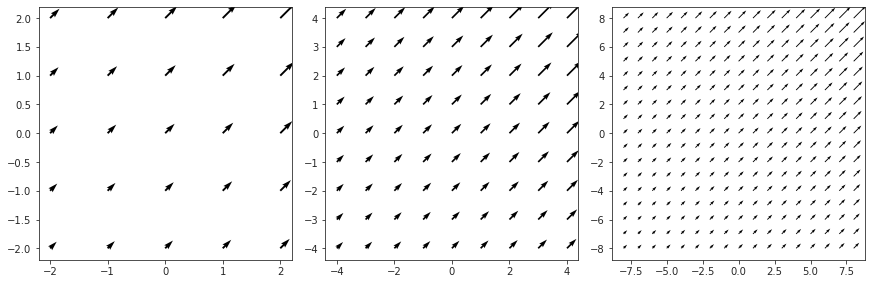

--------------------------------------------------------------------------------

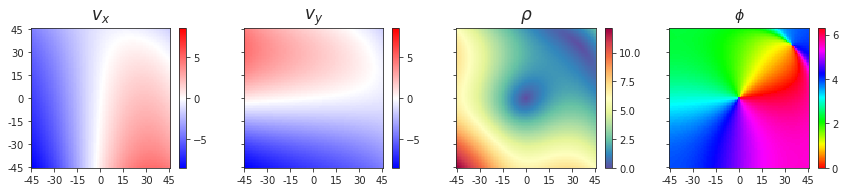

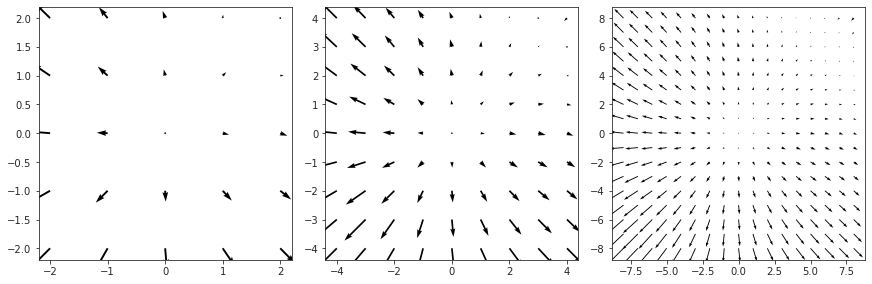

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.3 1. ],   velocity: [  0.   0. -10.]

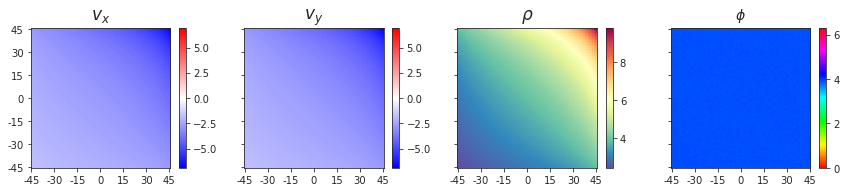

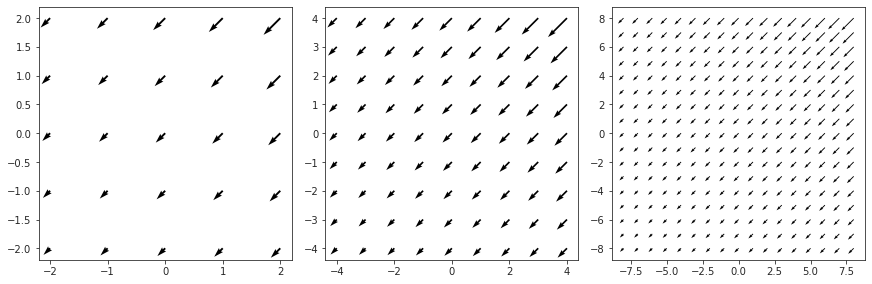

--------------------------------------------------------------------------------

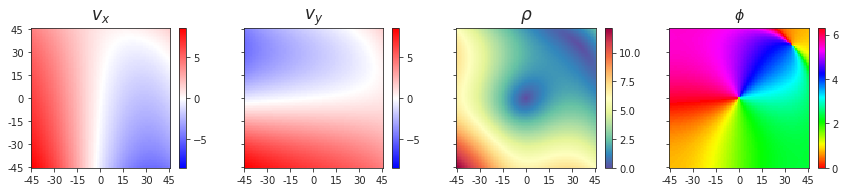

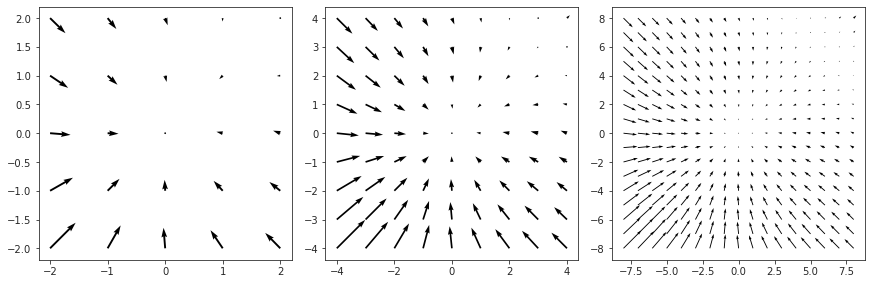

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.3 1. ],   velocity: [5. 5. 0.]

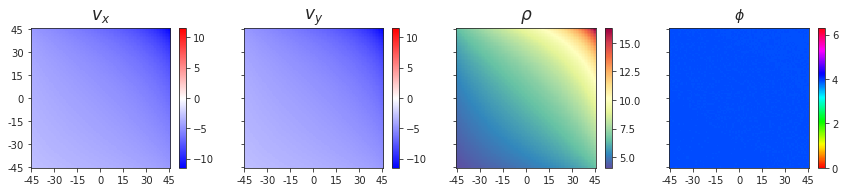

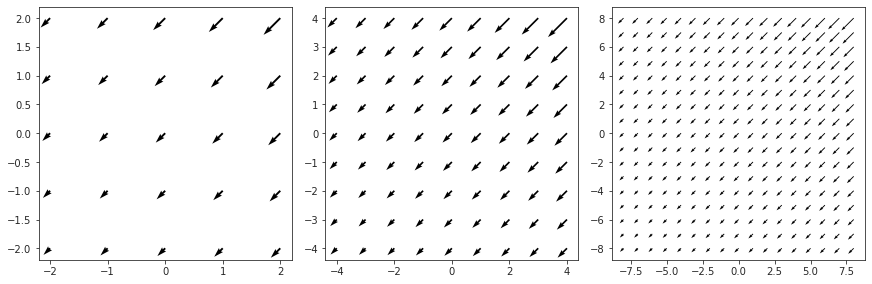

--------------------------------------------------------------------------------

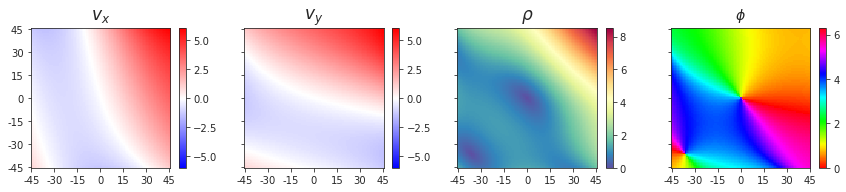

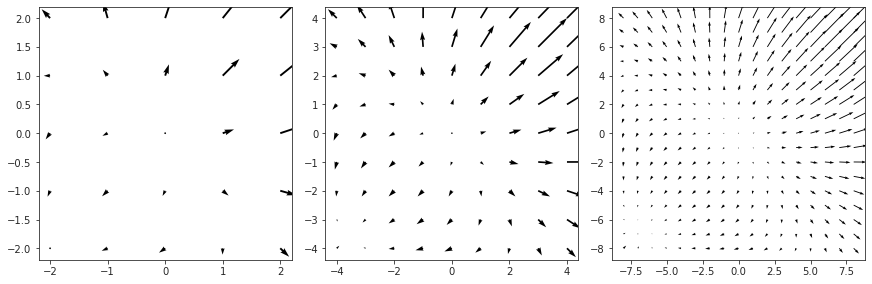

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.3 1. ],   velocity: [ 1. -2.  0.]

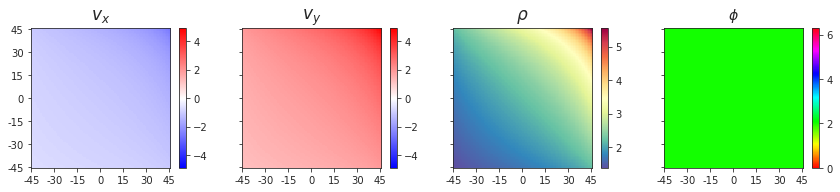

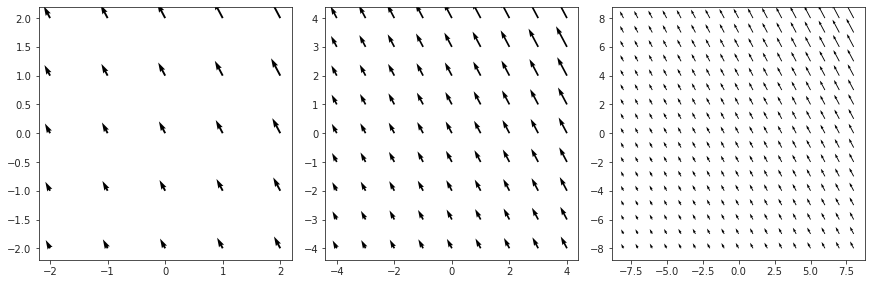

--------------------------------------------------------------------------------

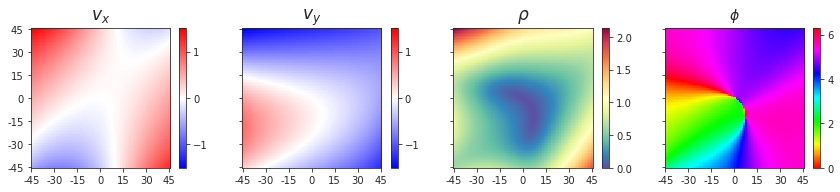

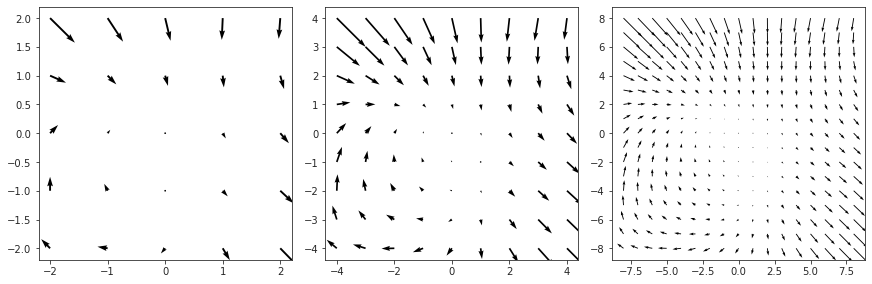

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.3 1. ],   velocity: [ 3.  0. 10.]

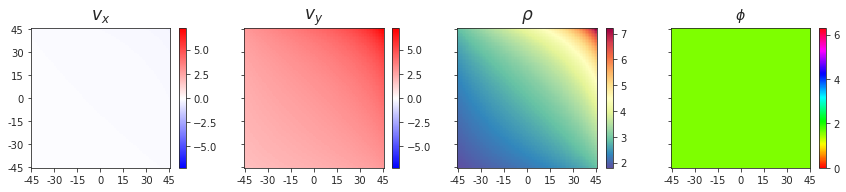

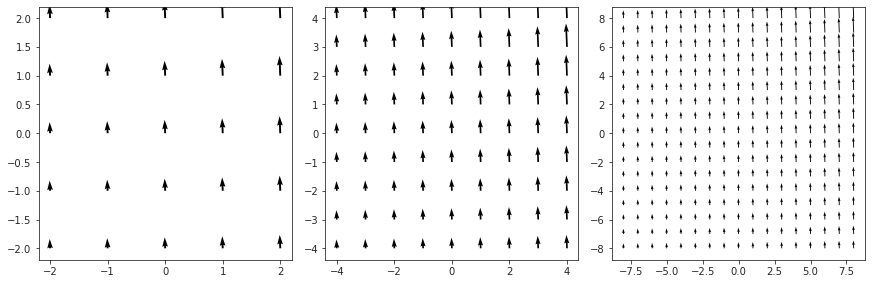

--------------------------------------------------------------------------------

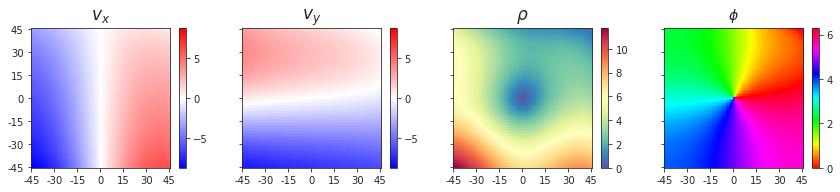

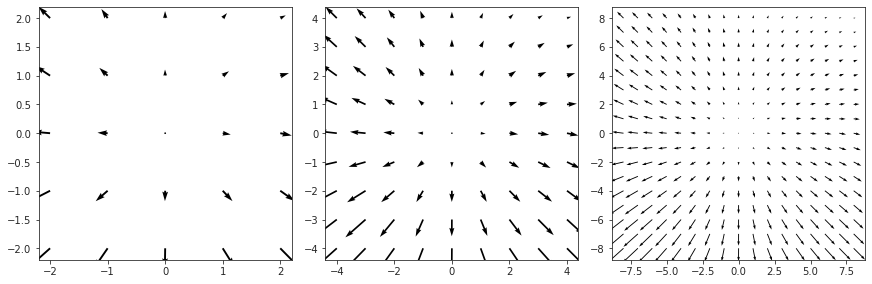

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.3 1. ],   velocity: [3. 3. 1.]

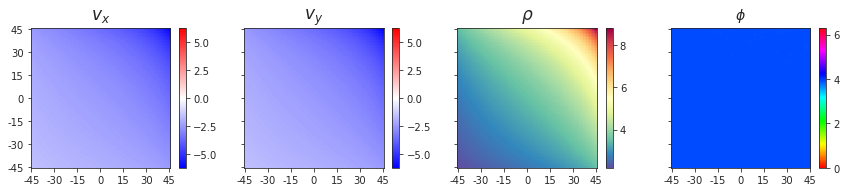

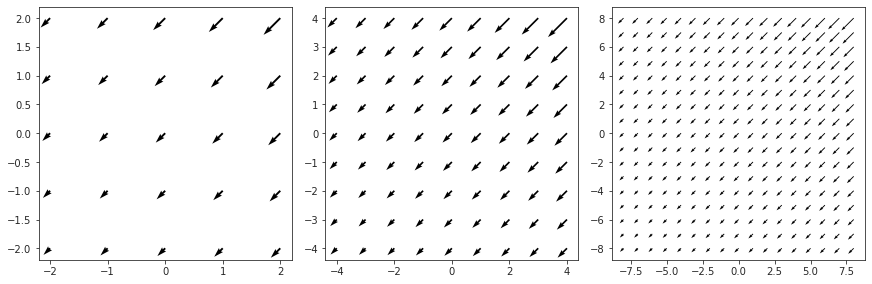

--------------------------------------------------------------------------------

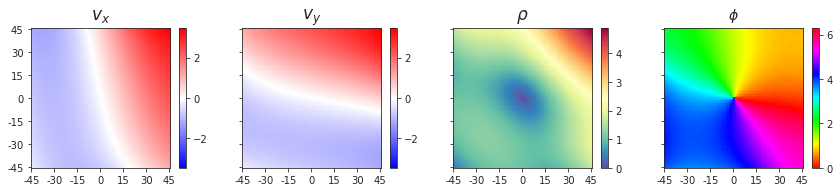

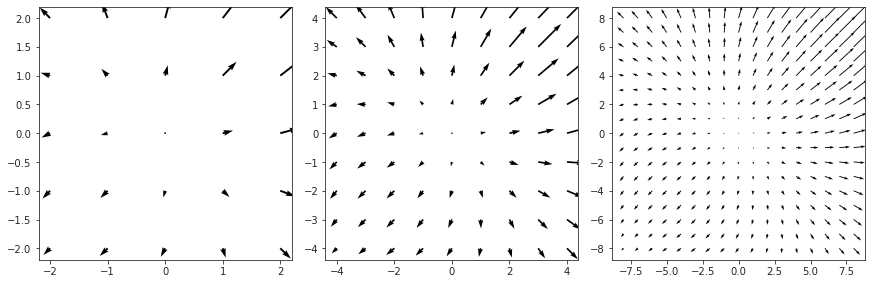

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

fixation: [0.3 0.3 1. ],   velocity: [-2.  1.  5.]

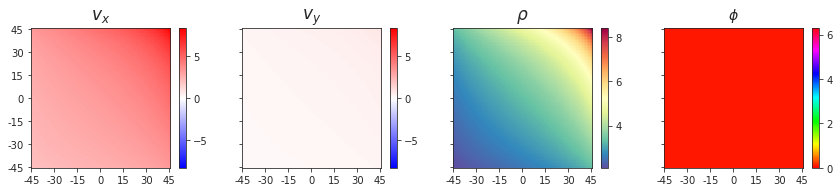

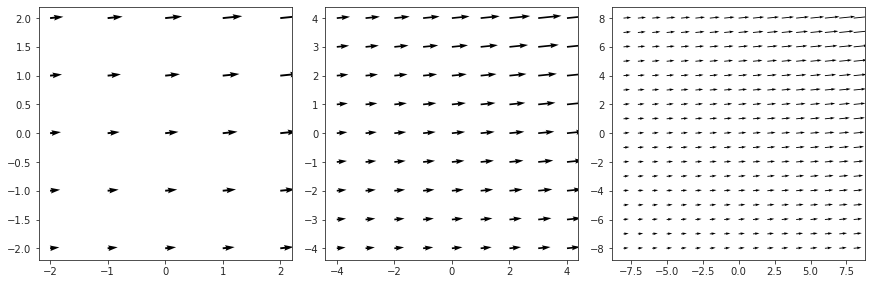

--------------------------------------------------------------------------------

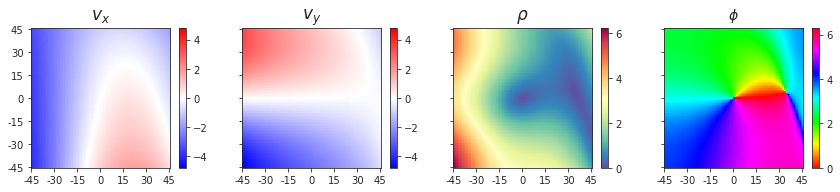

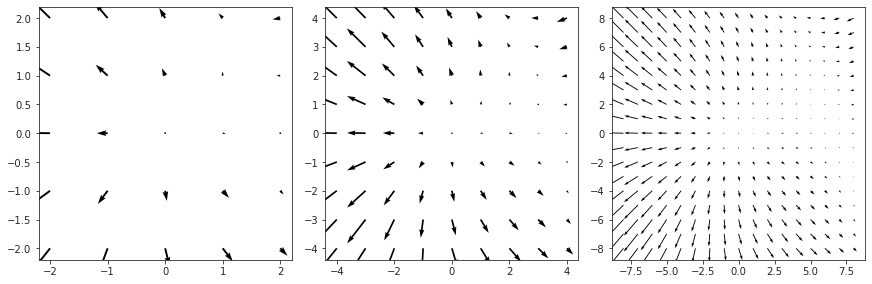

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------

In [26]:
for i in range(len(of.fix)):
    for j in range(of.vel.shape[1]):
        msg = f"fixation: {of.fix[i]},   "
        msg += f"velocity: {of.vel[:, j]}"
        print(msg)

        test = v_rot[i, ..., :2, j]
        show_velocity(test)
        show_opticflow(test)

        print('\n', '-' * 80, '\n')

        test = alpha_dot[i, ..., :2, j]
        show_velocity(test)
        show_opticflow(test)
        
        print('\n', '-' * 80)
        print('-' * 80, '\n\n\n')